# Time Series Multisteps Deep Learning Forecasting with Tensors - HARD MultiOutput

### From LSTM to Attention

In [1]:
#!pip uninstall -y keras tensorflow

In [2]:
#!pip install keras==2.8.0 tensorflow==2.8.0

In [3]:
#!pip install statsmodels

In [4]:
#!pip install keras-mdn-layer
#!pip install tensorflow_probability

In [5]:
#!pip install keras_multi_head
#!pip install keras-self-attention

In [6]:
#!pip install numba

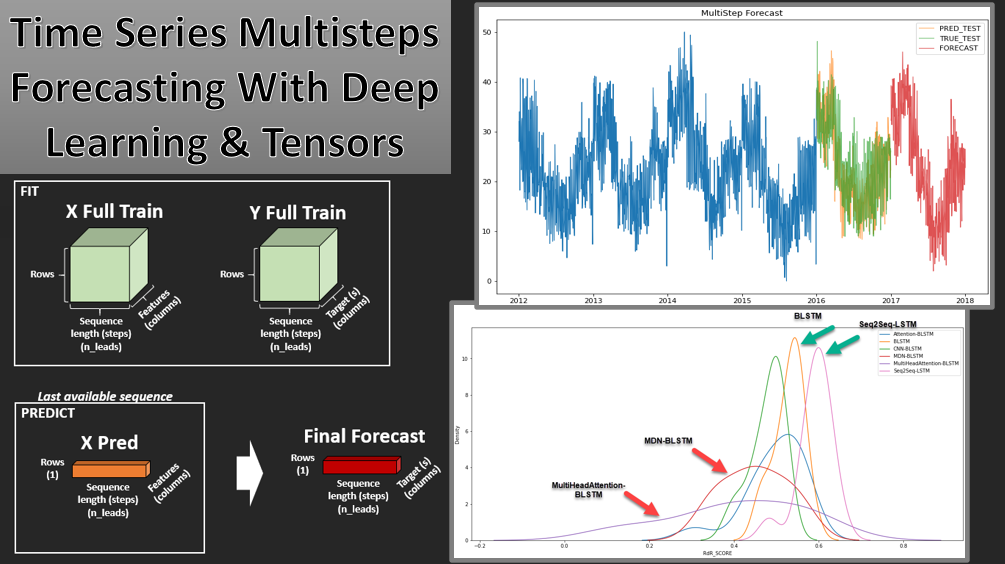

In [7]:
from IPython.display import Image
Image(filename='/opt/continuum/data/image/cover.png')

How can we forecast long-term multi-steps into the futur using deep learning models and tensors ? This article will deep dive this question using 3 different time series and a diversity of neural network architectures.

You will learn how to convert a dataframe time serie to a 3d tensor and then, how to forecasts multiple steps into the future while validating the results.

Enjoy!

 <a class="anchor" id="menu"></a>
# Table of content:

### [Section#1 - Data](#P1)
[1.1 Loading the Time Series](#section1.1)<br/>
[1.2 Exploring the Time Series](#section1.2)<br/>
        
### [Section#2 - Feature Engineering](#P2)
[2.1 Train-Test Split Scale](#section2.1)<br/>
[2.2 Feature Extraction - Seasonal Means](#section2.2)<br/>
[2.3 Feature Extraction - Lagged Values](#section2.3)<br/>
[2.4 Feature Extraction - Fourier terms](#section2.4)<br/>
[2.5 Final dataset - Merge all features + Differenciation, Seasonality, Trend](#section2.5)<br/>

### [Section#3 - From 2D Matrice to 3D Tensor](#P3)
[3.1 3D Train-Test set](#section3.1)<br/>
[3.2 3D Forecast set](#section3.2)<br/>

### [Section#4 - RdR Score Performance Metric](#P4)

### [Section#5 - BiLSTM](#P5)
[5.1 BiLSTM Architecture](#section5.1)<br/>
[5.2 BiLSTM Training](#section5.2)<br/>
[5.3 BiLSTM Validation](#section5.3)<br/>
[5.4 BiLSTM Multisteps Forecasting](#section5.4)<br/>

### [Section#6 - Time2Vec-BiLSTM](#P6)
[6.1 Time2Vec-BiLSTM Architecture](#section6.1)<br/>
[6.2 Time2Vec-BiLSTM Training](#section6.2)<br/>
[6.3 Time2Vec-BiLSTM Validation](#section6.3)<br/>
[6.4 Time2Vec-BiLSTM Multisteps Forecasting](#section6.4)<br/>



In [8]:
import os
#***********FIX the random seed for reproductible results. Different seed, different results!
seed_value = 1200
os.environ["PYTHONHASHSEED"] = str(seed_value)

import numpy as np
import tensorflow as tf
import random as python_random

def reset_seeds(seed_value):
   np.random.seed(seed_value) 
   python_random.seed(seed_value)
   tf.random.set_seed(seed_value)
   tf.keras.utils.set_random_seed(seed_value)

reset_seeds(seed_value) 

import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin
import matplotlib.pyplot as plt

from dateutil.relativedelta import relativedelta

from pandas.tseries.offsets import MonthEnd
from datetime import datetime, date
from datetime import date, timedelta
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, BatchNormalization, RepeatVector, TimeDistributed, Activation, Input, Lambda, Bidirectional, GlobalMaxPool1D
from keras.layers import Conv1D, MaxPooling1D, Flatten, Embedding, Dropout, dot, multiply, concatenate, Layer
from keras.callbacks import EarlyStopping, Callback
import keras.backend as K

from mdn import MDN, get_mixture_loss_func, sample_from_output
from keras_multi_head import MultiHead, MultiHeadAttention
from keras_self_attention import SeqSelfAttention

from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

<a class="anchor" id="P1"></a>
# Section#1 - Data

<a class="anchor" id="section1.1"></a>
### 1.1 - Loading the Time Series

Feel free to change it for your own time serie data and it should work! (just be sure that the dates and column type are correct)

In [9]:
ts_sequence = pd.read_csv('/opt/continuum/data/raw/easy_ts.csv', sep = ';') 
ts_sequence['DATE'] = pd.to_datetime(ts_sequence['DATE'])
result = seasonal_decompose(ts_sequence['EASY'], 
                                model='additive', period = 12, 
                                extrapolate_trend = 1)
ts_sequence['TREND'] = result.trend
ts_sequence['SEASONAL'] = result.seasonal
ts_sequence['RESID'] = result.resid
ts_sequence
print('ts_sequence', ts_sequence.shape)

ts_sequence (223, 5)


Defining the parameters of each time series

In [10]:
### Change parameters if needed!
dict_ts_sequence = {'dataset': ts_sequence.copy(), 
                    'dataset_orig': ts_sequence.copy(), 
                    'date_colname': 'DATE', #The date column name in dataframe
                    'y_colname' : ['TREND','SEASONAL', 'RESID'], #The time serie of interest (column name)
                    'stabilize_variance' : ['RESID'], 
                    'stabilize_mean' : ['TREND'], 
                    'seasonal_features' : True,
                    'diff_trend' : False,
                    'exog' : False,
                    'fourier_terms' : False,
                    'n_leads' : 24, #We will forecast 24 periods in the futur
                    'n_lags': 12, #We will keep 12 periods in the past as features
                    'freq': 12} #number of periods in a year (frequency): 4=quarterly, 12=monthly, 52=weekly, 365=daily


<a class="anchor" id="section1.2"></a>
### 1.1 - Exploring the Time Series

*WARNING: Here, we will only take a quick visual look at the time series as the goal is not to deep dive into time series analysis (can be a whole article just on this step!!!)

In [11]:
def exploring_time_serie(data, 
                         date_colname,
                         y_colname, 
                         exogenous = False):
    fig, ax = plt.subplots(figsize = (12, 6))
    ax.plot(data[date_colname], data[y_colname])
    plt.title('Time Serie of interest')
    plt.show()
    if exogenous == True:
        fig, ax = plt.subplots(figsize = (18, 9))
        print('Exogenous features - Multivariate')
        plt.title('Exogenous TIme Series (Multivariate)')
        for col in data.columns.difference([date_colname, 
                                            'Date', 'date']):
            print(col)
            if col == y_colname:
                ax.plot(data[date_colname], 
                    np.log1p(data[col]),
                       linewidth = 3)
            else:
                ax.plot(data[date_colname], 
                    np.log1p(data[col]),
                        linewidth = 1,
                       alpha = 0.6)

TREND


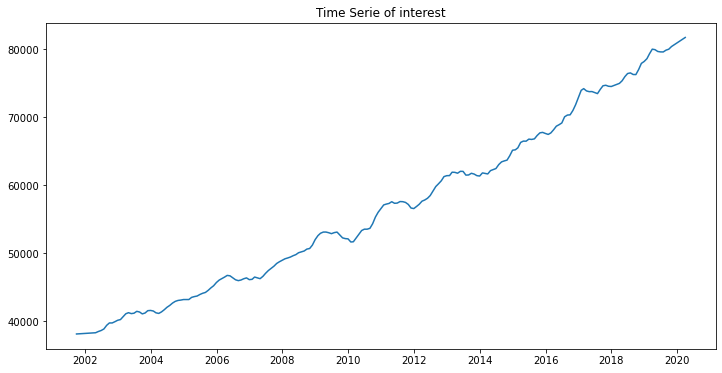

SEASONAL


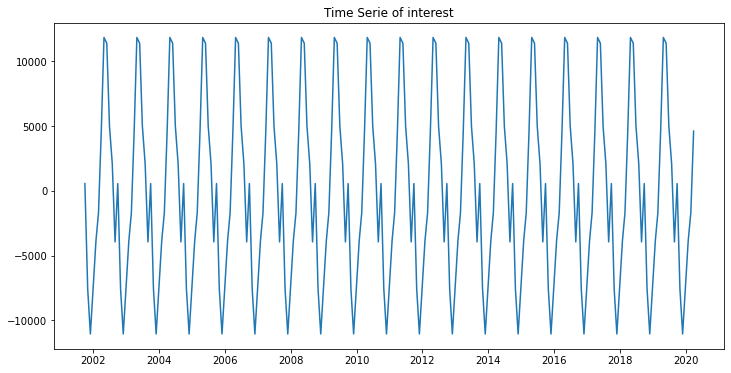

RESID


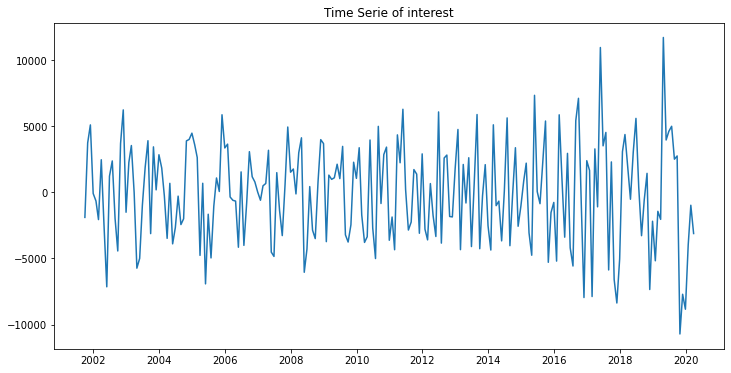

In [12]:
for y_colname in dict_ts_sequence['y_colname']:
    print(y_colname)
    exploring_time_serie(dict_ts_sequence['dataset'], 
                         dict_ts_sequence['date_colname'], 
                         y_colname)

This is a monthly time series. We will test and forecast 36 months into the futur.
We can observe that the time series is deterministic. There seems to have a strong positive trend and a strong monthly seasonality.

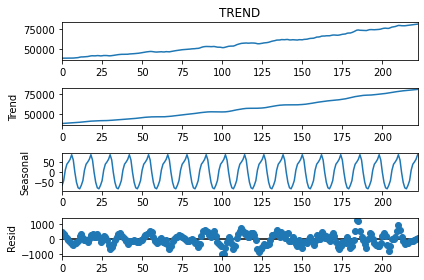

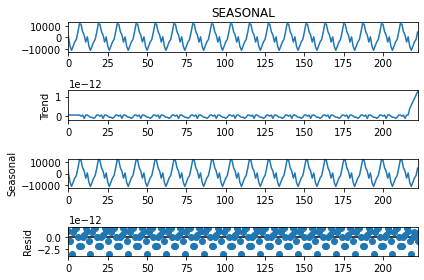

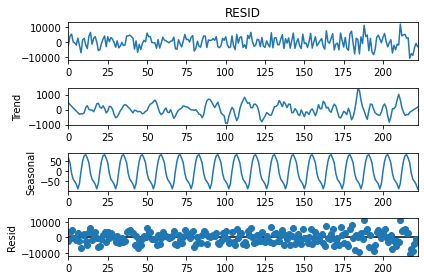

In [13]:
for y_colname in dict_ts_sequence['y_colname']:
    
    result = seasonal_decompose(ts_sequence[y_colname], 
                                model='additive', period = dict_ts_sequence['freq'], 
                                extrapolate_trend = 1)
    result.plot();

<a class="anchor" id="P1"></a>
# Section#2 - Feature Engineering

<a class="anchor" id="section2.1"></a>
### 2.1 - Train-Test Split Scale

We will start by splitting our dataset in Train and Test sets to be sure we do not include any overfitting features in our test set along the way. (Common mistake have seen soooo many times!). For example, we will calculate seasonal means. we HAVE TO get rid of the test set values BEFORE calculating the means or we will overfitting using test data in our train data.

In [14]:
def split_ts_train_test(ts,
                              date_colname,
                              y_colname_list,
                              n_leads):
    
    ts_train = ts.iloc[:-n_leads, :]
    ts_test = ts.iloc[-n_leads:, :]
    
   
    return ts, ts_train, ts_test

<a class="anchor" id="section2.2"></a>
### 2.2 - Feature Extraction - Functions

Now, we can calculate our seasonal means features only on the train set (as we are not supposed to know the test set in the feature !)

We will also extract seasonal means to help, again, our neural network model to capture seasonalities.

In [15]:
def seasonal_means_extract(dataset, date_colname, y_colname, n_leads, freq, y_scaler_sequence = None, drop_keys = False):
    """Calculate the seasonal means of a given time serie

    Args:
        dataset (dataframe): pandas dataframe
        date_colname (str): Name of the date column in the given dataframe
        y_colname (str): Name of the time serie column in the given dataframe
        n_leads (int): number of period to forecast into the futur
        freq (int): frequency, periods of the time series (1=yearly, 12=monthly, 52=weekly, 365=daily)

    Returns:
        list: a list of strings representing the header columns
    """
    keep_cols = list(dataset.columns)
    
    if y_scaler_sequence != None:
        y_scaled_feat = dataset[dataset.columns.difference([date_colname])]
        y_scaled_feat = y_scaler_sequence.inverse_transform(y_scaled_feat)
        for idx, col in enumerate(dataset.columns.difference([date_colname])):
            dataset[col] = y_scaled_feat[:, idx]
    

    timeserie = dataset[[date_colname, y_colname]].copy()

    timeserie.index.name = 'index'
    timeserie.index = pd.to_datetime(timeserie[date_colname])
    timeserie.index.name = 'index'
    
    min_year = np.min(timeserie.index.year)
    max_year = np.max(timeserie.index.year) + int(n_leads/freq) + 5

    all_dates = pd.DataFrame(pd.date_range(pd.to_datetime(str(min_year) + '-01-01'),
                  pd.to_datetime(str(max_year) + '-12-31')-timedelta(days=1),freq='d'), columns = ['ds'])

    if freq == 12:

        timeserie['MONTH'] = timeserie.index.month
        timeserie['QUARTER'] = timeserie.index.quarter

        months_mean = timeserie[['MONTH', y_colname]].groupby(['MONTH']).mean([y_colname]).reset_index()
        months_mean.columns = ['MONTH', 'MONTH_MEAN']
        timeserie = pd.merge(timeserie, months_mean, how = 'left', left_on = 'MONTH', right_on = 'MONTH')
        #del timeserie['MONTH']

        quarter_mean = timeserie[['QUARTER', y_colname]].groupby(['QUARTER']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['QUARTER', 'QUARTER_MEAN']
        timeserie = pd.merge(timeserie, quarter_mean, how = 'left', left_on = 'QUARTER', right_on = 'QUARTER')
        #del timeserie['QUARTER']
        
    elif freq == 4:    
        timeserie['QUARTER'] = timeserie.index.quarter.astype(str)
        quarter_mean = timeserie[['QUARTER', y_colname]].groupby(['QUARTER']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['QUARTER', 'QUARTER_MEAN']
        
        timeserie['YEAR'] = timeserie.index.year.astype(str)
        timeserie['QUARTER_YEAR'] = timeserie['YEAR'] + '_' + timeserie['QUARTER']

        all_dates['QUARTER'] = all_dates['ds'].dt.quarter.astype(str)
        all_dates['YEAR'] = all_dates['ds'].dt.year.astype(str)
        all_dates['QUARTER_YEAR'] = all_dates['YEAR'] + '_' + all_dates['QUARTER']
        all_dates = all_dates.groupby(['QUARTER_YEAR']).size().reset_index()
        all_dates.columns = ['QUARTER_YEAR', 'N_DAYS']
        

        timeserie1 = pd.merge(timeserie, quarter_mean, how = 'left', 
                              left_on = 'QUARTER', right_on = 'QUARTER')
        timeserie1.index = timeserie.index


    elif freq == 52:   
        timeserie['DAY_OF_MONTH'] = timeserie.index.day
        timeserie['DAY_OF_WEEK'] = timeserie.index.dayofweek
        timeserie['WEEK'] = timeserie.index.week
        timeserie['MONTH'] = timeserie.index.month
        timeserie['QUARTER'] = timeserie.index.quarter
        timeserie['MONTH_WEEK'] = timeserie['WEEK'].astype(str) + timeserie['MONTH'].astype(str)
        
        timeserie['YEAR'] = timeserie.index.year.astype(str)
        timeserie['WEEK_YEAR'] = timeserie['YEAR'].astype(str) + '_' + timeserie['WEEK'].astype(str)
        #del timeserie['YEAR']

        all_dates['WEEK'] = all_dates['ds'].dt.week.astype(str)
        all_dates['YEAR'] = all_dates['ds'].dt.year.astype(str)
        all_dates['WEEK_YEAR'] = all_dates['YEAR'] + '_' + all_dates['WEEK']
        all_dates = all_dates.groupby(['WEEK_YEAR']).size().reset_index()
        all_dates.columns = ['WEEK_YEAR', 'N_DAYS']

        #del timeserie['WEEK_YEAR']


        quarter_mean = timeserie[['WEEK', y_colname]].groupby(['WEEK']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['WEEK', 'WEEK_MEAN']
        timeserie = pd.merge(timeserie, quarter_mean, how = 'left', left_on = 'WEEK', right_on = 'WEEK')
        #del timeserie['WEEK']
        
        months_mean = timeserie[['MONTH', y_colname]].groupby(['MONTH']).mean([y_colname]).reset_index()
        months_mean.columns = ['MONTH', 'MONTH_MEAN']
        timeserie = pd.merge(timeserie, months_mean, how = 'left', left_on = 'MONTH', right_on = 'MONTH')
        #del timeserie['MONTH']
        
        quarter_mean = timeserie[['QUARTER', y_colname]].groupby(['QUARTER']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['QUARTER', 'QUARTER_MEAN']
        timeserie = pd.merge(timeserie, quarter_mean, how = 'left', left_on = 'QUARTER', right_on = 'QUARTER')
        #del timeserie['QUARTER']
        
        day_mean = timeserie[['DAY_OF_MONTH', y_colname]].groupby(['DAY_OF_MONTH']).mean([y_colname]).reset_index()
        day_mean.columns = ['DAY_OF_MONTH', 'DAY_OF_MONTH_MEAN']
        timeserie = pd.merge(timeserie, day_mean, how = 'left', left_on = 'DAY_OF_MONTH', right_on = 'DAY_OF_MONTH')
        #del timeserie['DAY_OF_MONTH']
        
        day_mean = timeserie[['DAY_OF_WEEK', y_colname]].groupby(['DAY_OF_WEEK']).mean([y_colname]).reset_index()
        day_mean.columns = ['DAY_OF_WEEK', 'DAY_OF_WEEK_MEAN']
        timeserie = pd.merge(timeserie, day_mean, how = 'left', left_on = 'DAY_OF_WEEK', right_on = 'DAY_OF_WEEK')
        #del timeserie['DAY_OF_WEEK']
    
    elif freq >= 100 and freq <= 600:    
        timeserie['DAY_OF_MONTH'] = timeserie.index.day
        timeserie['DAY_OF_WEEK'] = timeserie.index.dayofweek
        timeserie['WEEK'] = timeserie.index.week
        timeserie['QUARTER'] = timeserie.index.quarter
        timeserie['MONTH'] = timeserie.index.month
        timeserie['MONTH_WEEK'] = timeserie['WEEK'].astype(str) + timeserie['MONTH'].astype(str)
        timeserie['WEEKLY_MONTHLY'] = timeserie['DAY_OF_WEEK'].astype(str) + timeserie['WEEK'].astype(str) + timeserie['MONTH'].astype(str)
        
        timeserie = timeserie.fillna(0)
     
        day_mean = timeserie[['DAY_OF_MONTH', y_colname]].groupby(['DAY_OF_MONTH']).mean([y_colname]).reset_index()
        day_mean.columns = ['DAY_OF_MONTH', 'DAY_OF_MONTH_MEAN']
        timeserie = pd.merge(timeserie, day_mean, how = 'left', left_on = 'DAY_OF_MONTH', right_on = 'DAY_OF_MONTH')
        #del timeserie['DAY_OF_MONTH']
        
        day_mean = timeserie[['DAY_OF_WEEK', y_colname]].groupby(['DAY_OF_WEEK']).mean([y_colname]).reset_index()
        day_mean.columns = ['DAY_OF_WEEK', 'DAY_OF_WEEK_MEAN']
        timeserie = pd.merge(timeserie, day_mean, how = 'left', left_on = 'DAY_OF_WEEK', right_on = 'DAY_OF_WEEK')
        #del timeserie['DAY_OF_WEEK']
        
        quarter_mean = timeserie[['QUARTER', y_colname]].groupby(['QUARTER']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['QUARTER', 'QUARTER_MEAN']
        timeserie = pd.merge(timeserie, quarter_mean, how = 'left', left_on = 'QUARTER', right_on = 'QUARTER')
        #del timeserie['QUARTER']
        
        quarter_mean = timeserie[['WEEK', y_colname]].groupby(['WEEK']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['WEEK', 'WEEK_MEAN']
        timeserie = pd.merge(timeserie, quarter_mean, how = 'left', left_on = 'WEEK', right_on = 'WEEK')
        #del timeserie['WEEK']
        
        months_mean = timeserie[['MONTH', y_colname]].groupby(['MONTH']).mean([y_colname]).reset_index()
        months_mean.columns = ['MONTH', 'MONTH_MEAN']
        timeserie = pd.merge(timeserie, months_mean, how = 'left', left_on = 'MONTH', right_on = 'MONTH')
        #del timeserie['MONTH']
        
        model_mean = timeserie[['WEEKLY_MONTHLY', y_colname]].groupby(['WEEKLY_MONTHLY']).mean([y_colname]).reset_index()
        model_mean.columns = ['WEEKLY_MONTHLY', 'WEEKLY_MONTHLY_MEAN']
        timeserie = pd.merge(timeserie, model_mean, how = 'left', left_on = 'WEEKLY_MONTHLY', right_on = 'WEEKLY_MONTHLY')
        #del timeserie2['MEAN_MODEL']
    
    timeserie.index = pd.to_datetime(dataset[date_colname])
    
    if y_scaler_sequence != None:
        X_scaler = StandardScaler()
        for idx, col in enumerate([col for col in timeserie.columns if '_MEAN' in col]):
            timeserie[col] = X_scaler.fit_transform(timeserie[[col]])
            
        #for col in [col for col in timeserie.columns if '_MEAN' in col]:
            #timeserie[col] = y_scaler_sequence.transform(timeserie[[col]]).ravel()
    
    add_cols = list(set(keep_cols) - set(timeserie.columns))
    
    for col in add_cols:
        
        timeserie[col] = dataset[col]
    
    timeserie.index = pd.to_datetime(timeserie[date_colname])
    
    if drop_keys == True:
        return_cols = timeserie.columns[['_MEAN' in col for col in timeserie.columns]]
        timeserie = timeserie[return_cols]               
    return timeserie

TREND
SEASONALITIES


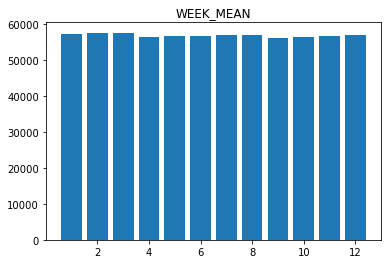

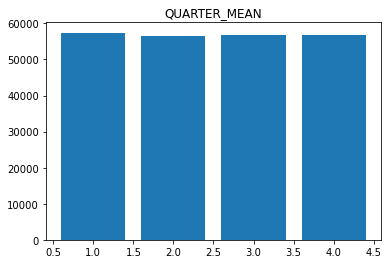

SEASONAL
SEASONALITIES


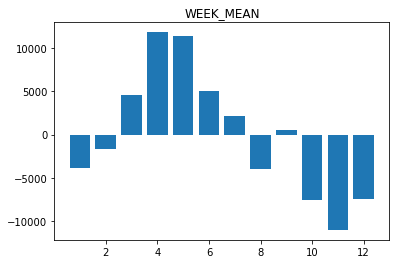

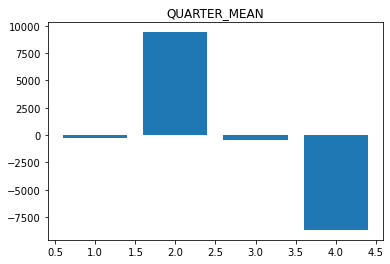

RESID
SEASONALITIES


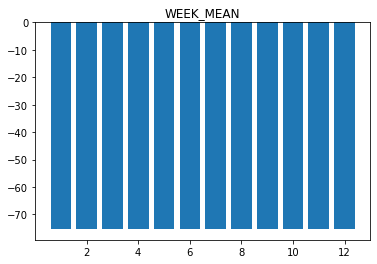

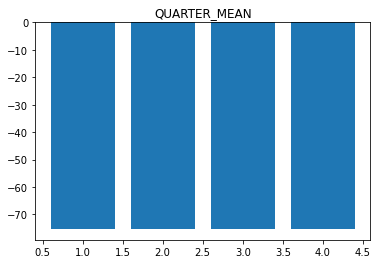

In [16]:
for y_colname in dict_ts_sequence['y_colname']:
    mean_df = seasonal_means_extract(dataset = dict_ts_sequence['dataset'], 
                                     date_colname = dict_ts_sequence['date_colname'], 
                                     y_colname= y_colname, 
                                     n_leads= dict_ts_sequence['n_leads'], 
                                     freq= dict_ts_sequence['freq'])
    
    print(y_colname)
    if dict_ts_sequence['freq'] == 12:
        print('SEASONALITIES')
        mean_df_distinct = mean_df[['MONTH','MONTH_MEAN']].drop_duplicates()
        plt.bar(mean_df_distinct['MONTH'], mean_df_distinct['MONTH_MEAN'])
        plt.title('WEEK_MEAN')
        plt.show()

        mean_df_distinct = mean_df[['QUARTER','QUARTER_MEAN']].drop_duplicates()
        plt.bar(mean_df_distinct['QUARTER'], mean_df_distinct['QUARTER_MEAN'])
        plt.title('QUARTER_MEAN')
        plt.show()
    else:
        print('SEASONALITIES')

        mean_df_distinct = mean_df[['DAY_OF_WEEK','DAY_OF_WEEK_MEAN']].drop_duplicates()
        plt.bar(mean_df_distinct['DAY_OF_WEEK'], mean_df_distinct['DAY_OF_WEEK_MEAN'])
        plt.title('DAY_OF_WEEK_MEAN')
        plt.show()

        mean_df_distinct = mean_df[['WEEK','WEEK_MEAN']].drop_duplicates()
        plt.bar(mean_df_distinct['WEEK'], mean_df_distinct['WEEK_MEAN'])
        plt.title('WEEK_MEAN')
        plt.show()

        mean_df_distinct = mean_df[['MONTH','MONTH_MEAN']].drop_duplicates()
        plt.bar(mean_df_distinct['MONTH'], mean_df_distinct['MONTH_MEAN'])
        plt.title('MONTH_MEAN')
        plt.show()

        mean_df_distinct = mean_df[['QUARTER','QUARTER_MEAN']].drop_duplicates()
        plt.bar(mean_df_distinct['QUARTER'], mean_df_distinct['QUARTER_MEAN'])
        plt.title('QUARTER_MEAN')
        plt.show()

        mean_df_distinct = mean_df[['WEEKLY_MONTHLY','WEEKLY_MONTHLY_MEAN']].drop_duplicates()
        plt.bar(mean_df_distinct['WEEKLY_MONTHLY'], mean_df_distinct['WEEKLY_MONTHLY_MEAN'])
        plt.title('WEEKLY_MONTH_MEAN')
        plt.show()

In [17]:
def merge_seasonal_features(dataset, seasonal_features, y_colname):
    timeserie = dataset.copy()
    
    timeserie.index = pd.to_datetime(timeserie.index)

    timeserie.index.name = 'index'

    
    timeserie['MONTH'] = timeserie.index.month
    timeserie['QUARTER'] = timeserie.index.quarter
    timeserie['DAY_OF_MONTH'] = timeserie.index.day
    timeserie['DAY_OF_WEEK'] = timeserie.index.dayofweek
    timeserie['WEEK'] = timeserie.index.week
    timeserie['MONTH'] = timeserie.index.month
    timeserie['QUARTER'] = timeserie.index.quarter
    #timeserie['WEEKLY_MONTHLY'] = timeserie['DAY_OF_WEEK'].astype(str) + timeserie['WEEK'].astype(str) + timeserie['MONTH'].astype(str)
    
    for feat in ['WEEK',
                 'MONTH',
                'QUARTER',
                'DAY_OF_MONTH',
                'DAY_OF_WEEK'
                #'WEEKLY_MONTHLY'
                ]:
        if feat in seasonal_features.columns:
            #print(feat, feat + '_MEAN_' + y_colname)
            seasonal_features_feat = seasonal_features[[feat, feat + '_MEAN_' + y_colname]].drop_duplicates().reset_index(drop = True)
            #print(seasonal_features_feat)
            timeserie = pd.merge(timeserie, seasonal_features_feat[[feat, feat + '_MEAN_' + y_colname]], how = 'left', left_on = feat, right_on = feat)
            del timeserie[feat]
        else:
            try:
                del timeserie[feat]
            except:
                pass
            pass
    
    #print(timeserie)
    for col in timeserie.columns:
        dataset[col] = timeserie[col].values
    
    return dataset

<a class="anchor" id="section2.3"></a>
### 2.3 - Feature Extraction - Lagged values

We will then convert our 1D time series into a 2D matrice with X features and y targets. The features will represent actual and lagged values while the targets will represent leaded values. This way, our model will be learning to extrapolate n_leads periods into the futur based on some features (multi-target regression problem).

In [18]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True, feat_str_at_end=True, feat_lag_str = 'TM', feat_lead_str = 'TP'):
    
    if feat_str_at_end == True:
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
          cols.append(df.shift(i))
          if i < 10:
              name_i = '0' + str(i)
          else:
              name_i = str(i)
              
          names += [(str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'') +'_' + feat_lag_str + name_i) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
          cols.append(df.shift(-i))
          if i == 0:
            names += [(str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'')) for j in range(n_vars)]
          else:
            if i < 10:
                name_i = '0' + str(i)
            else:
                name_i = str(i)
            names += [(str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'')+'_' + feat_lead_str + name_i) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
          agg.dropna(inplace=True)
    else:
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
          cols.append(df.shift(i))
          names += [(feat_lag_str + '%d' % (i) + str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'')) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
          cols.append(df.shift(-i))
          if i == 0:
            names += [(str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'')) for j in range(n_vars)]
          else:
            if i < 10:
                name_i = '0' + str(i)
            else:
                name_i = str(i)
            names += [(str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'')+'_' + feat_lead_str + name_i) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
          agg.dropna(inplace=True)
    return agg

For the sequence time series, we will add 12 lagged features (1 year in the past).
For the medium time series, we will add 365 lagged features (1 year in the past).
For the sequence time series, we will add 365 lagged features (1 year in the past).

Here,"TM" mean "Time Minus", soo it's a lagged n periods feature values of our time series.
Here,"TP" mean "Time Plus", soo it's a leaded n periods target values of our time series (the value we want to forecast into the future).
we juste created a multi-target regression dataframe.

We have to concatenate our seasonal features with our new matrice.

<a class="anchor" id="section2.4"></a>
### 2.4 - Feature Extraction - Fourier terms

In [19]:
def extract_fourier_terms(dataset):
    
    #ts_copy = dataset[[date_colname]]
    dataset['sin365_2'] = np.sin(2 * np.pi * dataset.index.dayofyear / 365.25)
    dataset['sin365_2'] = StandardScaler().fit_transform(dataset['sin365_2'].values.reshape(-1,1))
    
    dataset['sin365_4'] = np.sin(2 * np.pi * 2 * dataset.index.dayofyear / 365.25)
    dataset['sin365_4'] = StandardScaler().fit_transform(dataset['sin365_4'].values.reshape(-1,1))
    
    dataset['cos365_2'] = np.cos(2 * np.pi * dataset.index.dayofyear / 365.25)
    dataset['cos365_2'] = StandardScaler().fit_transform(dataset['cos365_2'].values.reshape(-1,1))
    
    dataset['cos365_4'] = np.cos(2 * np.pi * 2 * dataset.index.dayofyear / 365.25)
    dataset['cos365_4'] = StandardScaler().fit_transform(dataset['cos365_4'].values.reshape(-1,1))
    
    dataset['tanh365_2'] = np.tanh(2 * np.pi * dataset.index.dayofyear / 365.25)
    dataset['tanh365_2'] = StandardScaler().fit_transform(dataset['tanh365_2'].values.reshape(-1,1))
    
    dataset['tanh365_4'] = np.tanh(2 * np.pi * 2 * dataset.index.dayofyear / 365.25)
    dataset['tanh365_4'] = StandardScaler().fit_transform(dataset['tanh365_4'].values.reshape(-1,1))
    
    return dataset

<a class="anchor" id="section2.5"></a>
### 2.5 - Final dataset - Merge all features + Differenciation, Seasonality, Trend

In [20]:
def dataprep_pipeline(ts_data, 
                      dict_ts_sequence, 
                      seasonal_features = True,
                      diff_trend = True,
                      exog = True,
                      fourier_terms = True):
    ####SCALING
    y_scaler_forecast = StandardScaler()
    ts_sequence_forecast = ts_data.copy()
    ts_sequence_forecast

    y_data = ts_sequence_forecast[dict_ts_sequence['y_colname']].copy()

    y_data = pd.DataFrame(y_scaler_forecast.fit_transform(y_data))
    y_data.columns = dict_ts_sequence['y_colname']
    for y_colname in y_data.columns:
        ts_sequence_forecast[y_colname] = y_data[y_colname].values

    ###CALCULATE SEASONAL MEANS
    if seasonal_features == True:
        seasonal_list = []
        all_cols = [dict_ts_sequence['date_colname']] + dict_ts_sequence['y_colname']
        for idx, y_colname in enumerate(dict_ts_sequence['y_colname']):

            if idx == 0:
                ts_sequence_seasonal_feats_full = seasonal_means_extract(dataset = ts_data[all_cols], 
                                                                 date_colname = dict_ts_sequence['date_colname'], 
                                                                 y_colname= y_colname, 
                                                                 n_leads= dict_ts_sequence['n_leads'], 
                                                                 freq= dict_ts_sequence['freq'],
                                                                  y_scaler_sequence = y_scaler_forecast)
                del ts_sequence_seasonal_feats_full[dict_ts_sequence['date_colname']]
                del ts_sequence_seasonal_feats_full[y_colname]
            else:
                ts_sequence_seasonal_feats_full = seasonal_means_extract(dataset = ts_data[all_cols], 
                                                                 date_colname = dict_ts_sequence['date_colname'], 
                                                                 y_colname= y_colname, 
                                                                 n_leads= dict_ts_sequence['n_leads'], 
                                                                 freq= dict_ts_sequence['freq'],
                                                                  y_scaler_sequence = y_scaler_forecast,
                                                                  drop_keys = True)

            ts_sequence_seasonal_feats_full = ts_sequence_seasonal_feats_full[ts_sequence_seasonal_feats_full.columns.difference(dict_ts_sequence['y_colname'])]
            for col in ts_sequence_seasonal_feats_full.columns[['_MEAN' in col for col in ts_sequence_seasonal_feats_full.columns]]:
                ts_sequence_seasonal_feats_full[col + '_' + y_colname] = ts_sequence_seasonal_feats_full[col]
                del ts_sequence_seasonal_feats_full[col]

            seasonal_list.append(ts_sequence_seasonal_feats_full)

        ts_sequence_seasonal_feats_full = pd.concat(seasonal_list, axis = 1)
        #ts_sequence_seasonal_feats_full.head(1)

    ts_sequence_forecast.index = pd.to_datetime(ts_sequence_forecast['DATE'])
    
    ### CALCULATE LAGS
    supervised_list = []
    for y_colname in dict_ts_sequence['y_colname']:
        ts_sequence_supervised_full = series_to_supervised(ts_sequence_forecast[[y_colname]], 
                                                  n_in=dict_ts_sequence['n_lags'], 
                                                  n_out=1, 
                                                  dropnan=True, 
                                                  feat_str_at_end=True, 
                                                  feat_lag_str = 'TM', 
                                                  feat_lead_str = 'TP')
        supervised_list.append(ts_sequence_supervised_full)

        #rint(y_colname, ts_sequence_supervised_full.shape)

    ts_sequence_supervised_full = pd.concat(supervised_list, axis = 1)
    #ts_sequence_supervised_full.head(-1)

    ### MERGE SEASONAL MEANS
    if seasonal_features == True:
        for y_colname in dict_ts_sequence['y_colname']:
            ts_sequence_supervised_full = merge_seasonal_features(dataset = ts_sequence_supervised_full.copy(), 
                                                             seasonal_features = ts_sequence_seasonal_feats_full.copy(),
                                                             y_colname = y_colname)

    ### DIFF TREND
    if diff_trend == True:
        for y_colname in dict_ts_sequence['y_colname']:
            ts_sequence_supervised_full['DIFF_' + y_colname] = StandardScaler().fit_transform(ts_sequence_supervised_full[y_colname].diff().fillna(0).values.reshape(-1,1))

            decomp = seasonal_decompose(ts_sequence_supervised_full[y_colname], model='additive', period = 12, extrapolate_trend=1)
            ts_sequence_supervised_full['TREND_' + y_colname] = StandardScaler().fit_transform(decomp.trend.values.reshape(-1,1))
            #ts_sequence_supervised['SEASON'] = StandardScaler().fit_transform(decomp.seasonal.values.reshape(-1,1))

            #ts_sequence_supervised = extract_fourier_terms(ts_sequence_supervised.copy())                        

            #print(y_colname, ts_sequence_supervised_full.shape)
            #print(y_colname, ts_sequence_supervised_full.isnull().sum())

    ### EXOG
    if exog == True:
        exog_cols = []
        all_cols = dict_ts_sequence['y_colname'] + [dict_ts_sequence['date_colname'], 'Date','date']
        for col in ts_sequence.columns.difference(all_cols):
            exog_cols.append(col)

        dict_ts_sequence_exog = ts_sequence[exog_cols]

        exog_scaler = StandardScaler()
        dict_ts_sequence_exog = pd.DataFrame(exog_scaler.fit_transform(dict_ts_sequence_exog),
                                             index = pd.to_datetime(ts_sequence[dict_ts_sequence['date_colname']]),
                                             columns = exog_cols)


        for col in dict_ts_sequence_exog.columns:
            ts_sequence_supervised_full = pd.merge(ts_sequence_supervised_full, 
                                                   dict_ts_sequence_exog[[col]],
                                                  how = 'left',
                                                  left_index = True,
                                                  right_index = True)
    #ts_sequence_supervised_full.head(1).T
    
    return ts_sequence_supervised_full, y_scaler_forecast


In [21]:
ts_full, ts_train, ts_test = split_ts_train_test(ts = dict_ts_sequence['dataset_orig'].copy(),
                                                  date_colname = dict_ts_sequence['date_colname'],
                                                  y_colname_list = dict_ts_sequence['y_colname'],
                                                  n_leads = dict_ts_sequence['n_leads'])

from ts_transform import TransformerDiff, TransformerLog
diff_transformer_dict_train = {}
diff_transformer_dict_full = {}

log_transformer_dict_train = {}
log_transformer_dict_full = {}
#for y_colname in dict_ts_sequence['y_colname']:


from copy import deepcopy
if len(dict_ts_sequence['stabilize_variance']) > 0:
    for y_colname in dict_ts_sequence['stabilize_variance']:
        log_transformer_full = TransformerLog()
        ts_full[y_colname] = log_transformer_full.fit_transform(ts_full[[y_colname]].values)
        log_transformer_dict_full[y_colname] = deepcopy(log_transformer_full)
if len(dict_ts_sequence['stabilize_mean']) > 0:
    for y_colname in dict_ts_sequence['stabilize_mean']:
        diff_transformer_full = TransformerDiff()
        ts_full[y_colname] = diff_transformer_full.fit_transform(ts_full[[y_colname]].values)
        diff_transformer_dict_full[y_colname] = deepcopy(diff_transformer_full)
    
ts_full = ts_full.dropna()

"""
for y_colname in dict_ts_sequence['y_colname']:
    log_transformer = TransformerLog()
    diff_transformer = TransformerDiff()
    if dict_ts_sequence['stabilize_variance'] == True:
        ts_train[y_colname] = log_transformer.fit_transform(ts_train[[y_colname]].values)
        log_transformer_dict_train[y_colname] = log_transformer
    if dict_ts_sequence['stabilize_mean'] == True:
        ts_train[y_colname] = diff_transformer.fit_transform(ts_train[[y_colname]].values)
        diff_transformer_dict_train[y_colname] = diff_transformer
"""

if len(dict_ts_sequence['stabilize_variance']) > 0:
    for y_colname in dict_ts_sequence['stabilize_variance']:
        log_transformer = TransformerLog()
        ts_train[y_colname] = log_transformer.fit_transform(ts_train[[y_colname]].values)
        log_transformer_dict_train[y_colname] = deepcopy(log_transformer)
if len(dict_ts_sequence['stabilize_mean']) > 0:
    for y_colname in dict_ts_sequence['stabilize_mean']:
        diff_transformer = TransformerDiff()
        ts_train[y_colname] = diff_transformer.fit_transform(ts_train[[y_colname]].values)
        diff_transformer_dict_train[y_colname] = deepcopy(diff_transformer)
        
ts_train = ts_train.dropna()


ts_sequence_supervised_full, y_scaler_forecast = dataprep_pipeline(ts_full.copy(), 
                                                                  dict_ts_sequence, 
                                                                  seasonal_features = dict_ts_sequence['seasonal_features'],
                                                                  diff_trend = dict_ts_sequence['diff_trend'],
                                                                  exog = dict_ts_sequence['exog'],
                                                                  fourier_terms = dict_ts_sequence['fourier_terms'])

ts_sequence_supervised, y_scaler_train = dataprep_pipeline(ts_train.copy(), 
                                                              dict_ts_sequence, 
                                                              seasonal_features = dict_ts_sequence['seasonal_features'],
                                                              diff_trend = dict_ts_sequence['diff_trend'],
                                                              exog = dict_ts_sequence['exog'],
                                                              fourier_terms = dict_ts_sequence['fourier_terms'])

In [22]:
ts_full

,DATE,EASY,TREND,SEASONAL,RESID
1,2001-10-31,34356.014301,25.862519,-7550.869025,6.470692
2,2001-11-30,32241.130129,25.862519,-11049.601229,6.560172
3,2001-12-31,30689.355335,25.862519,-7437.331749,6.163988
4,2002-01-31,33737.956257,25.862519,-3847.300370,6.109385
5,2002-02-28,34506.836643,25.862519,-1696.803231,5.959447
...,...,...,...,...,...
218,2019-11-30,61880.876642,265.908799,-11049.601229,4.911137
219,2019-12-31,64627.475504,265.908799,-7437.331749,4.447483
220,2020-01-31,73349.805109,265.908799,-3847.300370,5.710695
221,2020-02-29,78767.492319,265.908799,-1696.803231,6.076975


In [23]:
ts_sequence_supervised_full

,TREND_TM12,TREND_TM11,TREND_TM10,TREND_TM09,TREND_TM08,TREND_TM07,TREND_TM06,TREND_TM05,TREND_TM04,TREND_TM03,...,RESID_TM03,RESID_TM02,RESID_TM01,RESID,MONTH_MEAN_TREND,QUARTER_MEAN_TREND,MONTH_MEAN_SEASONAL,QUARTER_MEAN_SEASONAL,MONTH_MEAN_RESID,QUARTER_MEAN_RESID
DATE,,,,,,,,,,,,,,,,,,,,,
2002-10-31,-0.586856,-0.586856,-0.586856,-0.586856,-0.586856,-0.586856,-0.586856,-0.040361,-0.187163,0.105974,...,0.548523,-0.192742,-0.799697,0.724931,0.891172,1.238780,-1.061693,-1.337057,-2.758882,-1.648595
2002-11-30,-0.586856,-0.586856,-0.586856,-0.586856,-0.586856,-0.586856,-0.040361,-0.187163,0.105974,1.180173,...,-0.192742,-0.799697,0.724931,1.023940,1.673874,1.238780,-1.561678,-1.337057,-1.013500,-1.648595
2002-12-31,-0.586856,-0.586856,-0.586856,-0.586856,-0.586856,-0.040361,-0.187163,0.105974,1.180173,0.517249,...,-0.799697,0.724931,1.023940,-0.097415,0.924325,1.238780,-1.045468,-1.337057,0.179698,-1.648595
2003-01-31,-0.586856,-0.586856,-0.586856,-0.586856,-0.040361,-0.187163,0.105974,1.180173,0.517249,-0.681076,...,0.724931,1.023940,-0.097415,0.532527,0.339016,0.483392,-0.532436,-0.029513,0.544315,0.779673
2003-02-28,-0.586856,-0.586856,-0.586856,-0.040361,-0.187163,0.105974,1.180173,0.517249,-0.681076,-0.040216,...,1.023940,-0.097415,0.532527,0.705363,0.377423,0.483392,-0.225121,-0.029513,0.322110,0.779673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-30,2.399214,0.301036,0.746923,1.776226,1.680395,-0.924321,-1.593003,-0.896518,-0.696208,0.239850,...,0.567310,0.600859,-9.925362,-2.145246,1.673874,1.238780,-1.561678,-1.337057,-1.013500,-1.648595
2019-12-31,0.301036,0.746923,1.776226,1.680395,-0.924321,-1.593003,-0.896518,-0.696208,0.239850,-0.210276,...,0.600859,-9.925362,-2.145246,-3.000459,0.924325,1.238780,-1.045468,-1.337057,0.179698,-1.648595
2020-01-31,0.746923,1.776226,1.680395,-0.924321,-1.593003,-0.896518,-0.696208,0.239850,-0.210276,0.689977,...,-9.925362,-2.145246,-3.000459,-0.670454,0.339016,0.483392,-0.532436,-0.029513,0.544315,0.779673


In [24]:
dict_ts_sequence['dataset_orig']

,DATE,EASY,TREND,SEASONAL,RESID
0,2001-09-30,36803.790806,38130.396931,563.472085,-1890.078209
1,2001-10-31,34356.014301,38156.259450,-7550.869025,3750.623876
2,2001-11-30,32241.130129,38182.121969,-11049.601229,5108.609389
3,2001-12-31,30689.355335,38207.984488,-7437.331749,-81.297404
4,2002-01-31,33737.956257,38233.847007,-3847.300370,-648.590380
...,...,...,...,...,...
218,2019-11-30,61880.876642,80637.523666,-11049.601229,-7707.045795
219,2019-12-31,64627.475504,80903.432465,-7437.331749,-8838.625212
220,2020-01-31,73349.805109,81169.341264,-3847.300370,-3972.235785
221,2020-02-29,78767.492319,81435.250064,-1696.803231,-970.954513


In [25]:
print(ts_sequence_supervised.shape, ts_sequence_supervised_full.shape)

(186, 45) (210, 45)


In [26]:
ts_sequence_supervised_full.columns

Index(['TREND_TM12', 'TREND_TM11', 'TREND_TM10', 'TREND_TM09', 'TREND_TM08',
       'TREND_TM07', 'TREND_TM06', 'TREND_TM05', 'TREND_TM04', 'TREND_TM03',
       'TREND_TM02', 'TREND_TM01', 'TREND', 'SEASONAL_TM12', 'SEASONAL_TM11',
       'SEASONAL_TM10', 'SEASONAL_TM09', 'SEASONAL_TM08', 'SEASONAL_TM07',
       'SEASONAL_TM06', 'SEASONAL_TM05', 'SEASONAL_TM04', 'SEASONAL_TM03',
       'SEASONAL_TM02', 'SEASONAL_TM01', 'SEASONAL', 'RESID_TM12',
       'RESID_TM11', 'RESID_TM10', 'RESID_TM09', 'RESID_TM08', 'RESID_TM07',
       'RESID_TM06', 'RESID_TM05', 'RESID_TM04', 'RESID_TM03', 'RESID_TM02',
       'RESID_TM01', 'RESID', 'MONTH_MEAN_TREND', 'QUARTER_MEAN_TREND',
       'MONTH_MEAN_SEASONAL', 'QUARTER_MEAN_SEASONAL', 'MONTH_MEAN_RESID',
       'QUARTER_MEAN_RESID'],
      dtype='object')

In [27]:
ts_sequence_supervised_full

,TREND_TM12,TREND_TM11,TREND_TM10,TREND_TM09,TREND_TM08,TREND_TM07,TREND_TM06,TREND_TM05,TREND_TM04,TREND_TM03,...,RESID_TM03,RESID_TM02,RESID_TM01,RESID,MONTH_MEAN_TREND,QUARTER_MEAN_TREND,MONTH_MEAN_SEASONAL,QUARTER_MEAN_SEASONAL,MONTH_MEAN_RESID,QUARTER_MEAN_RESID
DATE,,,,,,,,,,,,,,,,,,,,,
2002-10-31,-0.586856,-0.586856,-0.586856,-0.586856,-0.586856,-0.586856,-0.586856,-0.040361,-0.187163,0.105974,...,0.548523,-0.192742,-0.799697,0.724931,0.891172,1.238780,-1.061693,-1.337057,-2.758882,-1.648595
2002-11-30,-0.586856,-0.586856,-0.586856,-0.586856,-0.586856,-0.586856,-0.040361,-0.187163,0.105974,1.180173,...,-0.192742,-0.799697,0.724931,1.023940,1.673874,1.238780,-1.561678,-1.337057,-1.013500,-1.648595
2002-12-31,-0.586856,-0.586856,-0.586856,-0.586856,-0.586856,-0.040361,-0.187163,0.105974,1.180173,0.517249,...,-0.799697,0.724931,1.023940,-0.097415,0.924325,1.238780,-1.045468,-1.337057,0.179698,-1.648595
2003-01-31,-0.586856,-0.586856,-0.586856,-0.586856,-0.040361,-0.187163,0.105974,1.180173,0.517249,-0.681076,...,0.724931,1.023940,-0.097415,0.532527,0.339016,0.483392,-0.532436,-0.029513,0.544315,0.779673
2003-02-28,-0.586856,-0.586856,-0.586856,-0.040361,-0.187163,0.105974,1.180173,0.517249,-0.681076,-0.040216,...,1.023940,-0.097415,0.532527,0.705363,0.377423,0.483392,-0.225121,-0.029513,0.322110,0.779673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-30,2.399214,0.301036,0.746923,1.776226,1.680395,-0.924321,-1.593003,-0.896518,-0.696208,0.239850,...,0.567310,0.600859,-9.925362,-2.145246,1.673874,1.238780,-1.561678,-1.337057,-1.013500,-1.648595
2019-12-31,0.301036,0.746923,1.776226,1.680395,-0.924321,-1.593003,-0.896518,-0.696208,0.239850,-0.210276,...,0.600859,-9.925362,-2.145246,-3.000459,0.924325,1.238780,-1.045468,-1.337057,0.179698,-1.648595
2020-01-31,0.746923,1.776226,1.680395,-0.924321,-1.593003,-0.896518,-0.696208,0.239850,-0.210276,0.689977,...,-9.925362,-2.145246,-3.000459,-0.670454,0.339016,0.483392,-0.532436,-0.029513,0.544315,0.779673


<a class="anchor" id="P3"></a>
# Section#3 - From 2D Matrice to 3D Tensor

Now, if we want to convert this matrice in a 3d vector:

In [28]:
def prep_data_3d_arch1_multivar(data, y_colname_list, date_colname, n_leads):

    #timeserie = data.copy()
    n_step = n_leads
    
    timeserie = data.copy()

    Xtimeserie = timeserie[timeserie.columns.difference([date_colname])]
    ytimeserie = timeserie[y_colname_list]

    feats = list(Xtimeserie.columns)
    Xlist = []
    ylist = []
    i = 0
    for i in range(0, len(timeserie) - ((n_step*2)-1)):
        Xlist.append(np.array([Xtimeserie.iloc[i: i+n_step].values]))
        ylist.append(np.array([ytimeserie.iloc[i+n_step: i+(n_step*2)].values]))

    #return Xlist
    Xlist_T = np.array(Xlist).reshape(len(Xlist), n_step, len(Xtimeserie.columns))
    ylist_T = np.array(ylist).reshape(len(ytimeserie) - ((n_step*2)-1), n_step, len(ytimeserie.columns))

    XlistTest = []
    i = 0
    for i in range(len(Xtimeserie) - n_step, len(Xtimeserie)- (n_step-1)):
        XlistTest.append([Xtimeserie.iloc[i: i+n_step].values])
    XlistTest_T = np.array(XlistTest).reshape(1, n_step, len(Xtimeserie.columns))


    Xlist_T_all = Xlist_T.copy()
    ylist_T_all = ylist_T.copy()

    XlistTest_T_all = XlistTest_T.copy()
   
    return Xlist_T_all, ylist_T_all, XlistTest_T_all, feats

<a class="anchor" id="section3.1"></a>
### 3.1 - 3D Train-Test set

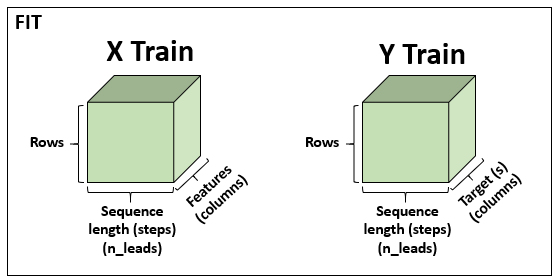

In [29]:
Image(filename='/opt/continuum/data/image/3DTensor-Fit.png')

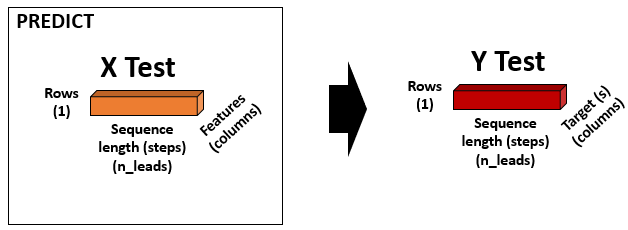

In [30]:
Image(filename='/opt/continuum/data/image/3DTensor-Predict.png')

In [31]:
X_train_sequence, y_train_sequence, X_test_sequence, feats = prep_data_3d_arch1_multivar(data = ts_sequence_supervised.copy(),
                                                                    y_colname_list = dict_ts_sequence['y_colname'],
                                                                    date_colname = dict_ts_sequence['date_colname'],
                                                                    n_leads = dict_ts_sequence['n_leads'])

print(X_train_sequence.shape, y_train_sequence.shape, X_test_sequence.shape)
#y_test is just the last Y sequence of n_leads form the original time serie

(139, 24, 45) (139, 24, 3) (1, 24, 45)


In [32]:
print(X_train_sequence.shape, y_train_sequence.shape)

dict_explain_tensor = {}
ijk = 0 
for val in X_train_sequence.shape:
    if ijk == 0:
        dict_explain_tensor[val] = 'Number of rows (Time occurences)'
    elif ijk == 1:
        dict_explain_tensor[val] = 'Sequence length - Number of steps to forecasts (n_leads)'
    elif ijk == 2:
        dict_explain_tensor[val] = 'Number of columns (Features)'
    print(val, dict_explain_tensor[val])
    ijk = ijk + 1

(139, 24, 45) (139, 24, 3)
139 Number of rows (Time occurences)
24 Sequence length - Number of steps to forecasts (n_leads)
45 Number of columns (Features)


In [33]:
print(X_test_sequence.shape)

(1, 24, 45)


<a class="anchor" id="section3.2"></a>
### 3.2 - 3D Forecast set

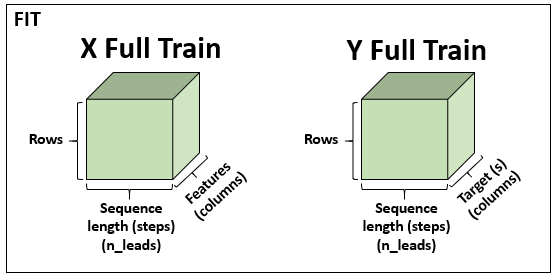

In [34]:
Image(filename='/opt/continuum/data/image/3DTensor-FullFit.png')

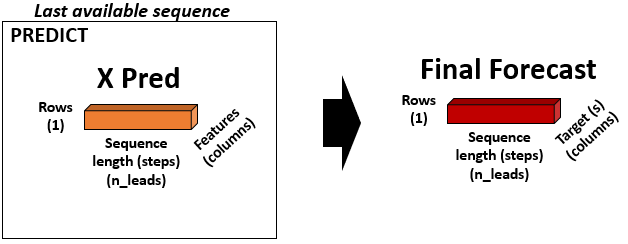

In [35]:
Image(filename='/opt/continuum/data/image/3DTensor-Forecast.png')

In [36]:
X_train_full, y_train_full, X_forecast, feats = prep_data_3d_arch1_multivar(data = ts_sequence_supervised_full.copy(),
                                                                    y_colname_list = dict_ts_sequence['y_colname'],
                                                                    date_colname = dict_ts_sequence['date_colname'],
                                                                    n_leads = dict_ts_sequence['n_leads'])

In [37]:
print(X_train_full.shape, y_train_full.shape)
dict_explain_full_tensor = {}
ijk = 0 
for val in X_train_full.shape:
    if ijk == 0:
        dict_explain_full_tensor[val] = 'Number of rows (Time occurences)'
    elif ijk == 1:
        dict_explain_full_tensor[val] = 'Sequence length - Number of steps to forecasts (n_leads)'
    elif ijk == 2:
        dict_explain_full_tensor[val] = 'Number of columns (Features)'
    print(val, dict_explain_full_tensor[val])
    ijk = ijk + 1

(163, 24, 45) (163, 24, 3)
163 Number of rows (Time occurences)
24 Sequence length - Number of steps to forecasts (n_leads)
45 Number of columns (Features)


<a class="anchor" id="P4"></a>
# Section#4 - RdR Score Performance Metric

The proposed RdR metric use: <br>
R: Naïve Random Walk <br>
d: Dynamic Time Warping <br>
R: Root Mean Squared Error <br>

The proposed RdR score technic will mainly answer three questions: <br>
#1 How can we take into account the shape similarity of a time series? : <br>
Answer: Dynamic Time Warping <br>

#2 How can we know if we should use our forecasting model or not? : <br>
Answer: Is it better or worst than a Naïve Random Walk? How Much ? (Well... also depends on your business goals here !) <br>

#3 How can we take into account the errors? : <br>
Answer: Root Mean Squared Error (RMSE) <br> 

0 = Performance same as a random walk model <br>
1 = Performance is perfect <br>
< 0 = Performance is worst than a random walk model <br>

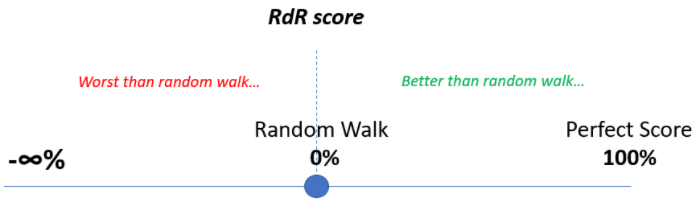

In [38]:
Image(filename='/opt/continuum/data/image/RdRScore.png')

If you want a better explaination of the RdR Score, follow the link bellow:

In [39]:
%%html
<a href="https://medium.com/@dave.cote.msc/rdr-score-metric-for-evaluating-time-series-forecasting-models-1c23f92f80e7">Click Me --> RdR Score on Medium</a>

In [40]:
from rdr_scorer import RdR_scorer
scorer_benchmark = RdR_scorer()

<a class="anchor" id="P5"></a>
# Section#5 - BLSTM

In [41]:
class PrintDot(Callback):
    def on_epoch_end(self, epoch, logs):
        #gc.collect()
        #tf.keras.backend.clear_session()
        if epoch % 100 == 0: print('')
        print(epoch,'.', end='')

<a class="anchor" id="section5.1"></a>
### 5.1 - BLSTM Architecture

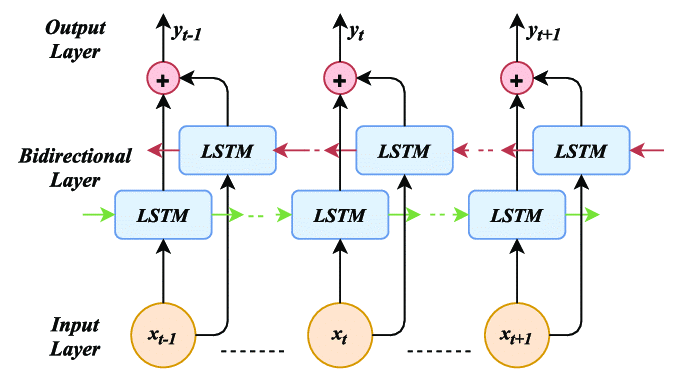

In [42]:
Image(filename='/opt/continuum/data/image/blstm.png')

In [43]:
from keras.layers import Dropout, Reshape, Concatenate, InputLayer, BatchNormalization

<a class="anchor" id="section5.2"></a>
### 5.2 - BLSTM Train

In [44]:
def create_bilstm_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(100, activation='tanh', 
                                 recurrent_activation="relu",
                                 return_sequences=False)))
    #model.add(Bidirectional(LSTM(100, activation='tanh', return_sequences=False, 
                                 #recurrent_activation="relu")))
    model.add(Dropout(0.1))
    model.add(Dense((y_train_sequence.shape[1] * y_train_sequence.shape[2]), activation = 'linear'))
    model.add(Reshape((y_train_sequence.shape[1], y_train_sequence.shape[2])))
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)
    model.compile(optimizer=opt, loss='mse')
    return model

model = create_bilstm_model()

2022-04-04 19:38:00.092903: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-04-04 19:38:00.092946: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-04 19:38:00.092976: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (anaconda-session-0642e1b2ba064820b8320b76c6599e10-d47fd44cfjfbq): /proc/driver/nvidia/version does not exist
2022-04-04 19:38:00.093269: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate com

In [45]:
y_train_sequence.shape

(139, 24, 3)

In [46]:
X_train_sequence.shape

(139, 24, 45)

In [47]:
#import gc
#gc.collect()
#gc.disable()

monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=20)
history = model.fit(X_train_sequence, 
                    y_train_sequence,
                    epochs=1000, 
                    batch_size = 24, 
                    #validation_split = 0.5, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])


0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .
100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .
200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .

In [48]:
testing= y_scaler_train.inverse_transform(pd.DataFrame(model.predict(X_test_sequence)[0, :, :]))
testing_pred = pd.DataFrame(testing)
testing_pred.columns = dict_ts_sequence['y_colname']
testing_pred

,TREND,SEASONAL,RESID
0,288.363739,5446.898438,6.080126
1,394.952515,5305.213867,5.707705
2,51.933643,3268.164062,5.898718
3,136.231537,6930.757324,6.349114
4,254.804871,1595.367798,6.028511
5,223.819992,-71.405182,5.878604
6,333.022980,-5523.692383,6.211515
7,413.611664,-7463.429199,6.194914
8,346.030945,-5632.493164,5.634664
9,222.024750,-5745.425781,6.292756


In [49]:
if len(dict_ts_sequence['stabilize_mean']) > 0:
    for y_colname in dict_ts_sequence['stabilize_mean']:
        testing_pred[y_colname] = diff_transformer_dict_train[y_colname].forecast_transform(testing_pred[[y_colname]].values)
if len(dict_ts_sequence['stabilize_variance']) > 0:
    for y_colname in dict_ts_sequence['stabilize_variance']:   
        testing_pred[y_colname] = log_transformer_dict_train[y_colname].inverse_transform(testing_pred[[y_colname]].values)

print_scaler_yes


In [50]:
testing_pred

,TREND,SEASONAL,RESID
0,75240.443840,5446.898438,51.990994
1,75635.396355,5305.213867,-2578.237880
2,75687.329998,3268.164062,-1351.412945
3,75823.561535,6930.757324,2662.804536
4,76078.366405,1595.367798,-373.546120
5,76302.186398,-71.405182,-1491.909460
6,76635.209377,-5523.692383,1239.743405
7,77048.821041,-7463.429199,1080.917444
8,77394.851986,-5632.493164,-2988.808946
9,77616.876736,-5745.425781,2056.173331


<a class="anchor" id="section5.3"></a>
### 5.3 - BLSTM Validation

TREND


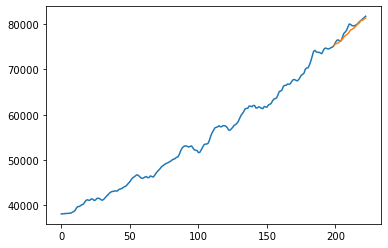

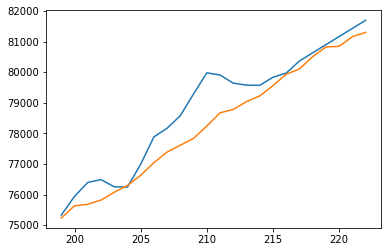

SEASONAL


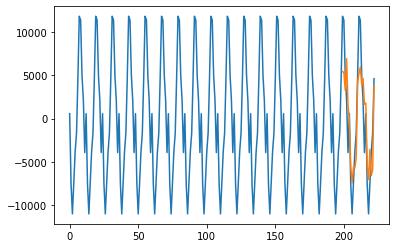

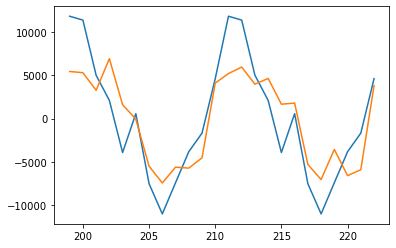

RESID


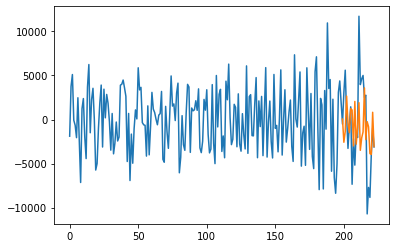

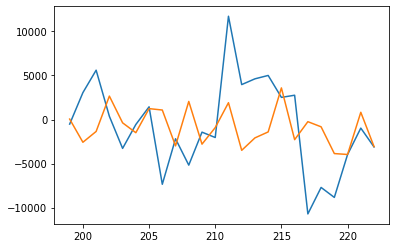

In [51]:
for idx, y_colname in enumerate(dict_ts_sequence['y_colname']):
    print(y_colname)
    plt.plot(dict_ts_sequence['dataset_orig'].index, dict_ts_sequence['dataset_orig'][dict_ts_sequence['y_colname'][idx]])
    plt.plot(testing_pred.index + (len(dict_ts_sequence['dataset_orig'])) - dict_ts_sequence['n_leads'] , testing_pred[dict_ts_sequence['y_colname'][idx]])
    plt.show()
    plt.plot(testing_pred.index + len(dict_ts_sequence['dataset_orig']) - dict_ts_sequence['n_leads'], 
             dict_ts_sequence['dataset_orig'][[dict_ts_sequence['y_colname'][idx]]].iloc[-dict_ts_sequence['n_leads']:, :].values)
    plt.plot(testing_pred.index + len(dict_ts_sequence['dataset_orig']) - dict_ts_sequence['n_leads'], testing_pred[dict_ts_sequence['y_colname'][idx]])
    plt.show()
    

In [52]:
pred_all = testing_pred.copy()

In [53]:
#pred_all.columns = ['Y_PRED']
for col in pred_all.columns:
    pred_all[col] = pred_all[col].astype(float)

In [54]:
testing_pred.index = pd.to_datetime(dict_ts_sequence['dataset_orig'].iloc[-dict_ts_sequence['n_leads']:, :][dict_ts_sequence['date_colname']]).values

In [55]:
scorer_benchmark_dict = {}

for idx, y_colname in enumerate(dict_ts_sequence['y_colname']):
    ts_orig = dict_ts_sequence['dataset_orig'][[dict_ts_sequence['date_colname'], y_colname]]
    ts_orig.index = pd.to_datetime(ts_orig[dict_ts_sequence['date_colname']])
    new_df_pred = pred_all[[y_colname]]
    new_df_pred.columns = ['Y_PRED']
    new_df_pred[y_colname] = dict_ts_sequence['dataset_orig'][[dict_ts_sequence['y_colname'][idx]]].iloc[-dict_ts_sequence['n_leads']:, :].values
    new_df_pred.index = testing_pred.index
    scorer_benchmark = RdR_scorer()
    scorer_benchmark.fit(ts_orig.copy(), 
                         y_colname = y_colname, 
                         n_step = dict_ts_sequence['n_leads'], 
                         y_true = new_df_pred[[y_colname]].copy(), 
                         y_pred = new_df_pred[['Y_PRED']].copy(), 
                         model_name = y_colname + '_BLSTM', 
                         freq = dict_ts_sequence['freq'])
    scorer_benchmark_dict[y_colname] = scorer_benchmark;
    


2020-04-30 00:00:00 2022-03-31 00:00:00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.24559D+00    |proj g|=  1.28236D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      2      1     0     0   3.452D-06   7.246D+00
  F =   7.2455854933270771     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


2020-04-30 00:00:00 2022-03-31 00:00:00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.90265D+00    |proj g|=  8.89067D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   8.891D-07   9.903D+00
  F =   9.9026531581733295     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


2020-04-30 00:00:00 2022-03-31 00:00:00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.89907D+00    |proj g|=  8.91909D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   8.919D-07   9.899D+00
  F =   9.8990728223646034     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


TREND 0.8641041207595417


SEASONAL 0.5744485346740634


RESID 0.2446977015500975




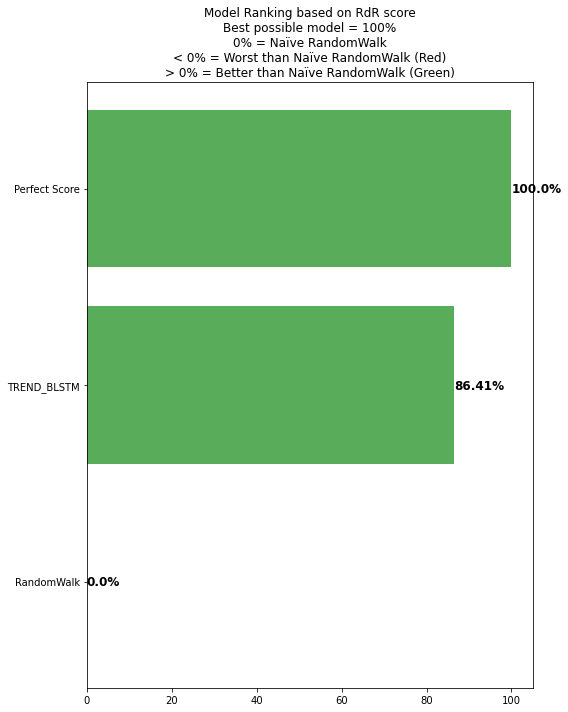

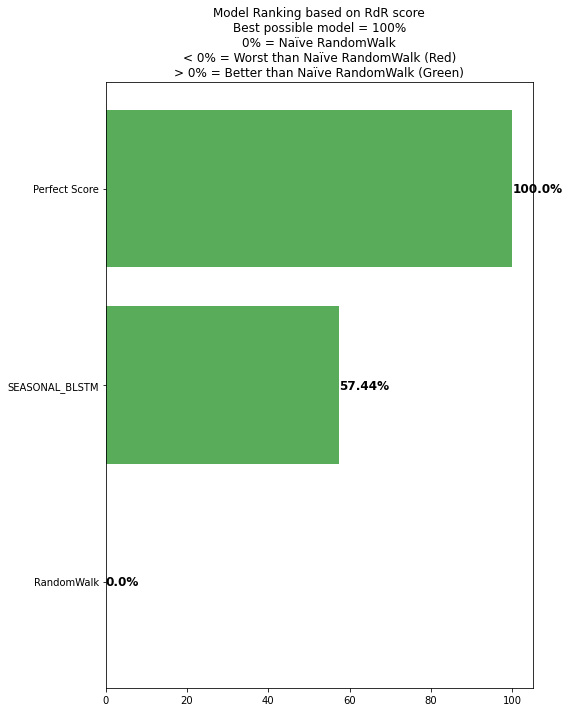

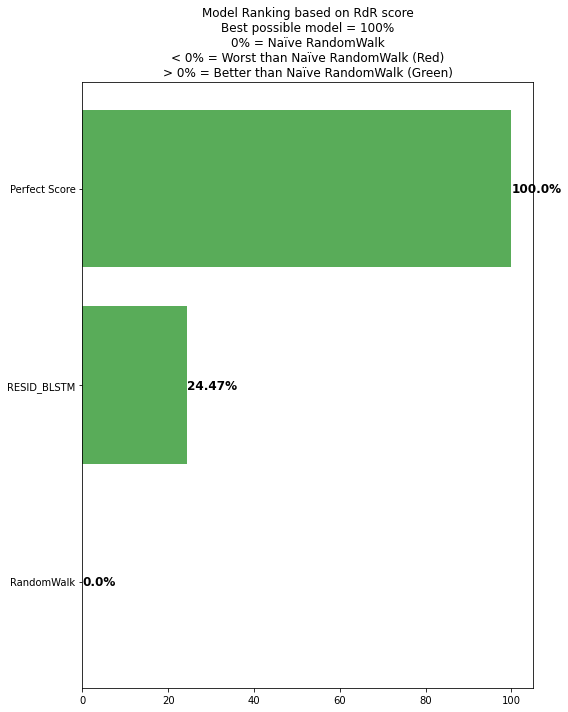

In [56]:
for y_colname, scorer in scorer_benchmark_dict.items():
    print(y_colname, scorer.get_df_viz()['RdR_SCORE'].values[0] )
    scorer.plot_rdr_rank()
    scorer.get_rdr_interpretation()
    print('\n')

In [57]:
def get_pred_dates(freq, X_pred, date_colname, n_leads):
    X_pred.index = pd.to_datetime(X_pred[date_colname])
    if freq == 12:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(months=1)+ MonthEnd(0) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(months=i) + MonthEnd(0)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]  
    
    elif freq == 52:
        print(X_pred.index)
        print(max(X_pred.index))
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(weeks=1) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(weeks=i)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]    
            
    elif freq == 4:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(months=3)+ MonthEnd(0) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(months=i*3) + MonthEnd(0)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]    
    
    elif freq == 2:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(months=6)+ MonthEnd(0) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(years=i*6) + MonthEnd(0)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]  
            
    elif freq == 1:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(years=1)+ MonthEnd(0) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(years=i) + MonthEnd(0)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]  
            
    elif freq >= 250 and freq <= 368:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(days=1) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(days=i)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]   
            
    elif freq == 1638:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=60)])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i*60) ])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]   
            
    elif freq == 3276:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=30) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i*30) ])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]   
    
    elif freq == 6552:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=15) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i*15)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]    
            
    elif freq == 9828:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=10)])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i*10)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]  
            
    elif freq == 19656:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=5)])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i*5)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]    
            
    elif freq == 98280:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=1)])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]  
            
    return X_pred_date

<a class="anchor" id="section5.4"></a>
### 5.4 - BLSTM Forecast

In [58]:
model = create_bilstm_model()

In [59]:
#import gc
#gc.collect()
#gc.disable()

monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=20)
history = model.fit(X_train_full, 
                    y_train_full,
                    epochs=1000, 
                    batch_size = 24, 
                    #validation_split = 0.1, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])


0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .
100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .
200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .

In [60]:
testing= y_scaler_forecast.inverse_transform(pd.DataFrame(model.predict(X_forecast)[0, :, :]))
forecast_pred = pd.DataFrame(testing)
forecast_pred.columns = dict_ts_sequence['y_colname']
forecast_pred

,TREND,SEASONAL,RESID
0,-114.895950,7006.446289,7.003222
1,321.807922,6921.841309,6.527313
2,184.324570,14109.081055,6.604608
3,53.773544,5375.479492,5.866061
4,101.472107,-2675.173096,5.614967
5,12.238662,1908.967041,5.328030
6,-80.516556,-2099.666748,5.419501
7,80.746376,-12020.384766,5.708456
8,437.744537,-5306.002930,6.217230
9,369.472626,-7919.106934,5.875239


In [61]:
for col in forecast_pred.columns:
    forecast_pred[col] =forecast_pred[col].astype(float)

In [62]:
if len(dict_ts_sequence['stabilize_mean']) > 0:
    for y_colname in dict_ts_sequence['stabilize_mean']:
        forecast_pred[y_colname] = diff_transformer_dict_full[y_colname].forecast_transform(forecast_pred[[y_colname]].values)
if len(dict_ts_sequence['stabilize_variance']) > 0:
    for y_colname in dict_ts_sequence['stabilize_variance']:   
        forecast_pred[y_colname] = log_transformer_dict_full[y_colname].inverse_transform(forecast_pred[[y_colname]].values)

print_scaler_yes


In [63]:
ts_orig = dict_ts_sequence['dataset_orig'][[dict_ts_sequence['date_colname']]]
ts_orig.index = pd.to_datetime(ts_orig[dict_ts_sequence['date_colname']])

In [64]:
X_pred_date = get_pred_dates(dict_ts_sequence['freq'], ts_orig, dict_ts_sequence['date_colname'], dict_ts_sequence['n_leads'])
forecast_pred.index = X_pred_date.index

In [65]:
forecast_pred

,TREND,SEASONAL,RESID
DATE,,,
2020-04-30,81586.262913,7006.446289,13952.887248
2020-05-31,81908.070835,6921.841309,4595.748025
2020-06-30,82092.395405,14109.081055,5829.508788
2020-07-31,82146.168949,5375.479492,-2831.825958
2020-08-31,82247.641056,-2675.173096,-4591.609414
2020-09-30,82259.879718,1908.967041,-6129.504189
2020-10-31,82179.363162,-2099.666748,-5686.261376
2020-11-30,82260.109538,-12020.384766,-3987.415228
2020-12-31,82697.854075,-5306.002930,502.506035


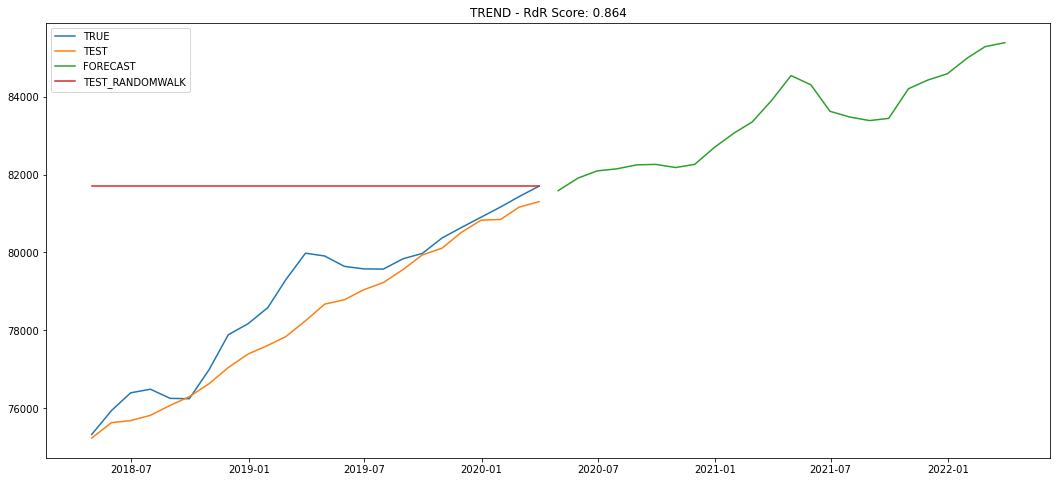

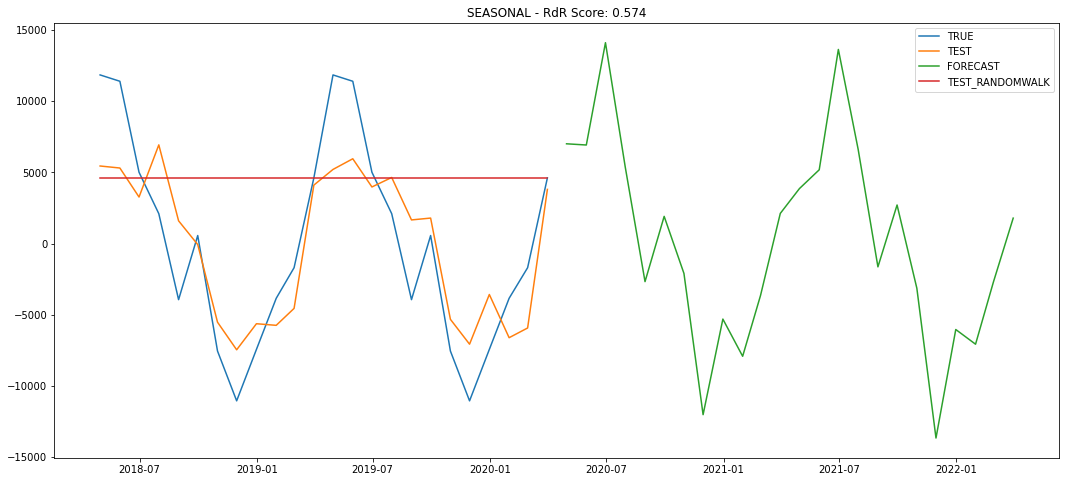

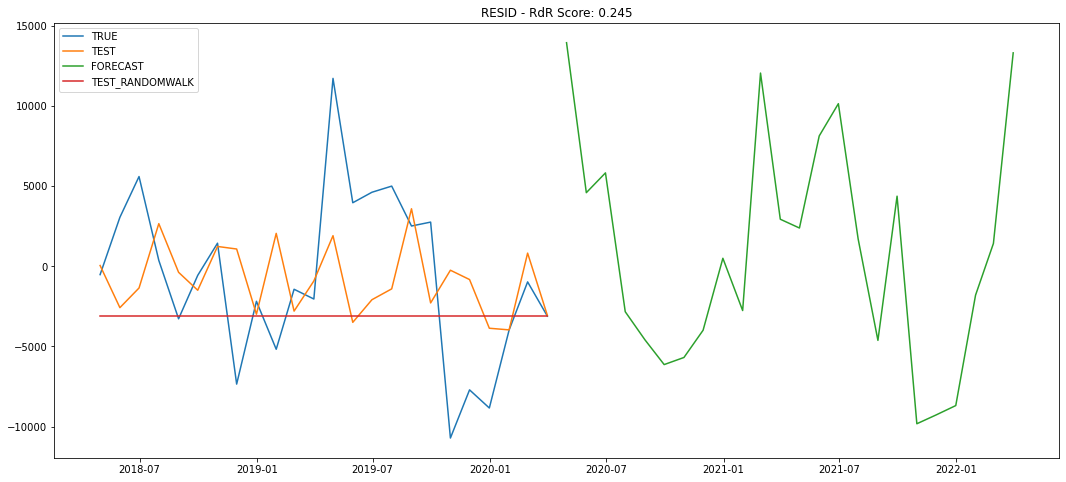

In [66]:
for idx, y_colname in enumerate(dict_ts_sequence['y_colname']):
    fig, ax = plt.subplots(figsize=(18,8))
    ax.plot(testing_pred.index, 
             dict_ts_sequence['dataset_orig'][[dict_ts_sequence['y_colname'][idx]]].iloc[-dict_ts_sequence['n_leads']:, :].values, label = 'TRUE')
    ax.plot(testing_pred.index, testing_pred[y_colname], label = 'TEST')
    ax.plot(forecast_pred.index, forecast_pred[y_colname], label = 'FORECAST')
    ax.plot(testing_pred.index, scorer_benchmark_dict[y_colname]._pred_rw['Y_PRED'].values, label = 'TEST_RANDOMWALK')
    plt.legend()
    plt.title(y_colname + ' - RdR Score: ' + str(round(scorer_benchmark_dict[y_colname].get_df_viz()['RdR_SCORE'].values[0], 3)))
    plt.show()

<a class="anchor" id="P6"></a>
# Section#6 - Time2Vec-BiLSTM

<a class="anchor" id="section6.1"></a>
### 6.1 - Time2Vec-BiLSTM Architecture

In [67]:
class Time2Vec(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(Time2Vec, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(Time2Vec, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)

In [68]:
def create_t2v_bilstm_timedistributed():
    inp = Input(shape=(X_train_sequence.shape[1],
                   X_train_sequence.shape[2]))
    x = Time2Vec(100)(inp)
    x = Bidirectional(LSTM(100, activation='tanh', return_sequences = True))(inp)
    x = TimeDistributed(Dense(y_train_sequence.shape[2], activation = 'linear'))(x)

    model = Model(inp, x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='mse')
    model.summary()
    
    return model

In [69]:
def create_t2v_bilstm_reshape():
    inp = Input(shape=(X_train_sequence.shape[1],
                   X_train_sequence.shape[2]))
    x = Time2Vec(100)(inp)
    x = Bidirectional(LSTM((y_train_sequence.shape[1] * y_train_sequence.shape[2]), 
                           activation='tanh', return_sequences = False))(x)
    x = Dense((y_train_sequence.shape[1] * y_train_sequence.shape[2]), activation = 'linear')(x)
    x = Reshape((y_train_sequence.shape[1], y_train_sequence.shape[2]))(x)

    model = Model(inp, x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=True)
    model.compile(optimizer=opt, loss='mse')
    model.summary()
    
    return model

<a class="anchor" id="section6.2"></a>
### 6.2 - Time2Vec-BiLSTM Train

In [70]:
model = create_t2v_bilstm_timedistributed()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 45)]          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 24, 200)          116800    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 24, 3)            603       
 ibuted)                                                         
                                                                 
Total params: 117,403
Trainable params: 117,403
Non-trainable params: 0
_________________________________________________________________


In [71]:
X_train_sequence.shape

(139, 24, 45)

In [72]:
y_train_sequence.shape

(139, 24, 3)

In [73]:
monitor_label = 'val_loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=20)
history = model.fit(X_train_sequence, 
                    y_train_sequence,
                    epochs=5000, 
                    batch_size = 24, #100
                    validation_data = (X_train_full[-dict_ts_sequence['n_leads']:, :, :],
                                       y_train_full[-dict_ts_sequence['n_leads']:, :, :]), 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])


0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .
100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .
200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .217 .218 .219 .220 .22

<a class="anchor" id="section6.3"></a>
### 6.3 - Time2Vec-BiLSTM Validation

In [74]:
testing= y_scaler_train.inverse_transform(pd.DataFrame(model.predict(X_test_sequence)[0, :, :]))
testing_pred = pd.DataFrame(testing)
testing_pred.columns = dict_ts_sequence['y_colname']
testing_pred

,TREND,SEASONAL,RESID
0,158.364136,9916.366211,5.839443
1,-48.703487,10214.128906,5.867986
2,-30.257870,4429.921387,6.510046
3,270.583221,113.844307,6.262753
4,584.938416,-1226.898315,5.760799
5,348.353943,-446.794312,6.305566
6,230.218201,-6475.504883,5.810159
7,781.009094,-9987.065430,4.447627
8,748.673035,-7446.566895,5.396025
9,170.356445,-713.729736,5.798926


TREND


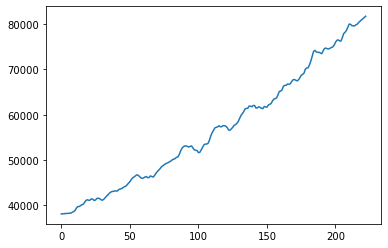

SEASONAL


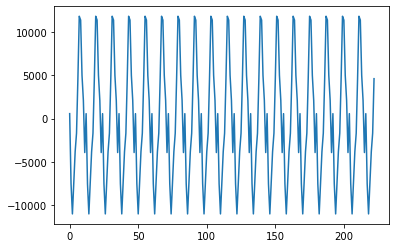

RESID


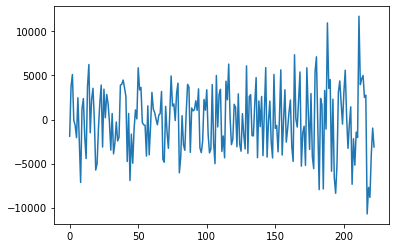

In [75]:
for idx, y_colname in enumerate(dict_ts_sequence['y_colname']):
    print(y_colname)
    plt.plot(dict_ts_sequence['dataset_orig'].index, dict_ts_sequence['dataset_orig'][dict_ts_sequence['y_colname'][idx]])
    plt.show()

In [76]:
if len(dict_ts_sequence['stabilize_mean']) > 0:
    for y_colname in dict_ts_sequence['stabilize_mean']:
        testing_pred[y_colname] = diff_transformer_dict_train[y_colname].forecast_transform(testing_pred[[y_colname]].values)
if len(dict_ts_sequence['stabilize_variance']) > 0:
    for y_colname in dict_ts_sequence['stabilize_variance']:   
        testing_pred[y_colname] = log_transformer_dict_train[y_colname].inverse_transform(testing_pred[[y_colname]].values)

print_scaler_yes


TREND


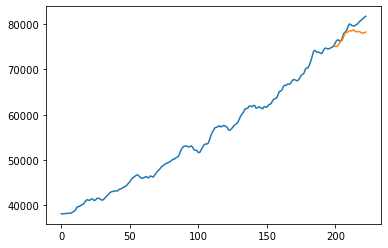

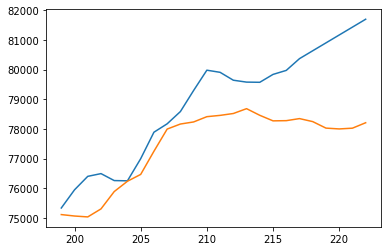

SEASONAL


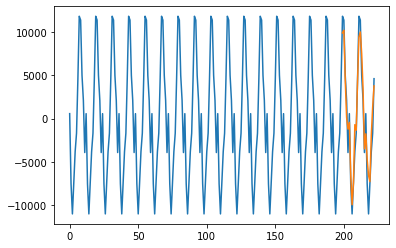

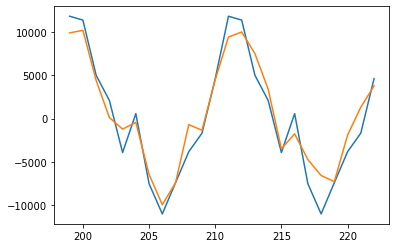

RESID


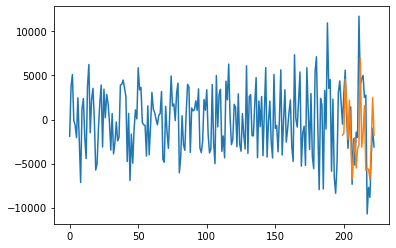

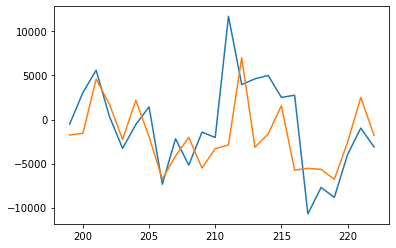

In [77]:
for idx, y_colname in enumerate(dict_ts_sequence['y_colname']):
    print(y_colname)
    plt.plot(dict_ts_sequence['dataset_orig'].index, dict_ts_sequence['dataset_orig'][dict_ts_sequence['y_colname'][idx]])
    plt.plot(testing_pred.index + (len(dict_ts_sequence['dataset_orig'])) - dict_ts_sequence['n_leads'] , testing_pred[dict_ts_sequence['y_colname'][idx]])
    plt.show()
    plt.plot(testing_pred.index + len(dict_ts_sequence['dataset_orig']) - dict_ts_sequence['n_leads'], 
             dict_ts_sequence['dataset_orig'][[dict_ts_sequence['y_colname'][idx]]].iloc[-dict_ts_sequence['n_leads']:, :].values)
    plt.plot(testing_pred.index + len(dict_ts_sequence['dataset_orig']) - dict_ts_sequence['n_leads'], testing_pred[dict_ts_sequence['y_colname'][idx]])
    plt.show()

In [78]:
pred_all = testing_pred.copy()

In [79]:
testing_pred.index = pd.to_datetime(dict_ts_sequence['dataset_orig'].iloc[-dict_ts_sequence['n_leads']:, :][dict_ts_sequence['date_colname']]).values

In [80]:
scorer_benchmark_dict = {}

for idx, y_colname in enumerate(dict_ts_sequence['y_colname']):
    ts_orig = dict_ts_sequence['dataset_orig'][[dict_ts_sequence['date_colname'], y_colname]]
    ts_orig.index = pd.to_datetime(ts_orig[dict_ts_sequence['date_colname']])
    new_df_pred = pred_all[[y_colname]]
    new_df_pred.columns = ['Y_PRED']
    new_df_pred[y_colname] = dict_ts_sequence['dataset_orig'][[dict_ts_sequence['y_colname'][idx]]].iloc[-dict_ts_sequence['n_leads']:, :].values
    new_df_pred.index = testing_pred.index
    scorer_benchmark = RdR_scorer()
    scorer_benchmark.fit(ts_orig.copy(), 
                         y_colname = y_colname, 
                         n_step = dict_ts_sequence['n_leads'], 
                         y_true = new_df_pred[[y_colname]].copy(), 
                         y_pred = new_df_pred[['Y_PRED']].copy(), 
                         model_name = y_colname + '_BLSTM', 
                         freq = dict_ts_sequence['freq'])
    scorer_benchmark_dict[y_colname] = scorer_benchmark;

2020-04-30 00:00:00 2022-03-31 00:00:00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.24559D+00    |proj g|=  1.28236D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      2      1     0     0   3.452D-06   7.246D+00
  F =   7.2455854933270771     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


2020-04-30 00:00:00 2022-03-31 00:00:00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.90265D+00    |proj g|=  8.89067D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   8.891D-07   9.903D+00
  F =   9.9026531581733295     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


2020-04-30 00:00:00 2022-03-31 00:00:00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.89907D+00    |proj g|=  8.91909D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   8.919D-07   9.899D+00
  F =   9.8990728223646034     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


TREND 0.5102057442514534


SEASONAL 0.7692806114588298


RESID 0.34322151008149127




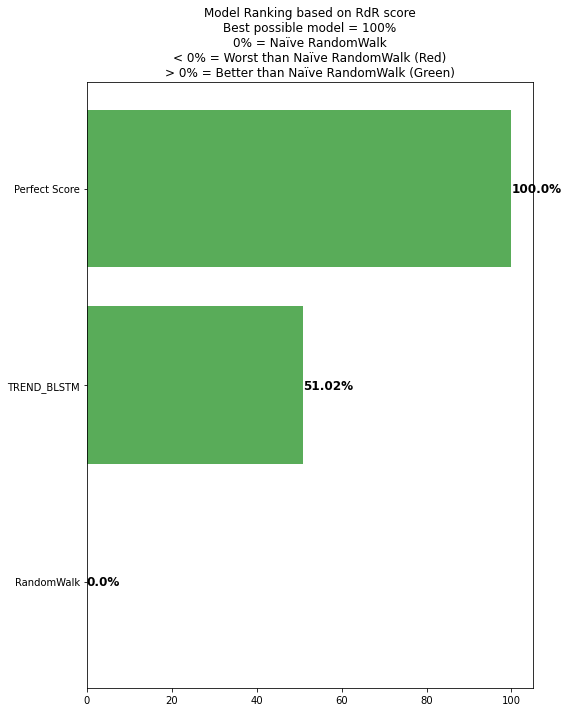

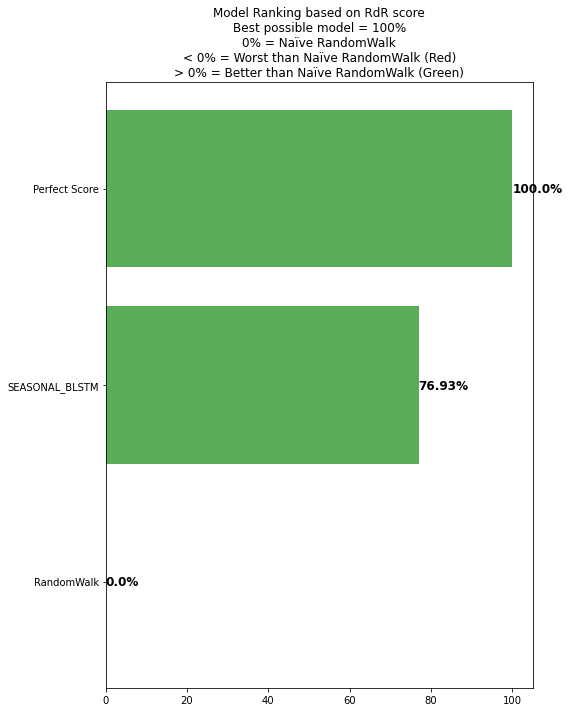

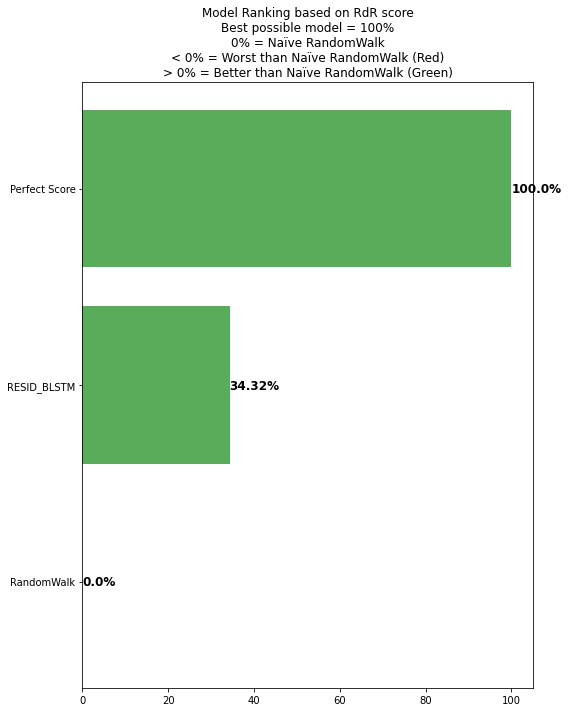

In [81]:
for y_colname, scorer in scorer_benchmark_dict.items():
    print(y_colname, scorer.get_df_viz()['RdR_SCORE'].values[0] )
    scorer.plot_rdr_rank()
    scorer.get_rdr_interpretation()
    print('\n')

<a class="anchor" id="section6.4"></a>
### 6.4 - Time2Vec-BiLSTM Forecast

In [82]:
model = create_t2v_bilstm_timedistributed()

monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=20)
history = model.fit(X_train_full, 
                    y_train_full,
                    epochs=5000, 
                    batch_size = 24, 
                    #validation_split = 0.1, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24, 45)]          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 24, 200)          116800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 24, 3)            603       
 tributed)                                                       
                                                                 
Total params: 117,403
Trainable params: 117,403
Non-trainable params: 0
_________________________________________________________________

0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48

In [83]:
testing= y_scaler_forecast.inverse_transform(pd.DataFrame(model.predict(X_forecast)[0, :, :]))
forecast_pred = pd.DataFrame(testing)
forecast_pred.columns = dict_ts_sequence['y_colname']
forecast_pred

,TREND,SEASONAL,RESID
0,477.174896,10121.226562,6.410466
1,461.330994,10572.062500,6.518858
2,199.224487,5661.705566,6.146573
3,241.461670,1267.587158,6.609391
4,392.368591,-3166.009277,6.238792
5,406.648926,342.132446,5.662068
6,820.406616,-8967.424805,5.433832
7,1142.920898,-12740.815430,5.384983
8,1000.652954,-8227.239258,5.888342
9,496.192444,-4574.185547,5.501069


In [84]:
#forecast_pred = pd.DataFrame(y_scaler_forecast.inverse_transform(pd.DataFrame(model.predict(X_forecast)[0, :, :])))

In [85]:
#plt.plot(forecast_pred)

In [86]:
#plt.plot(forecast_pred['SEASONAL'])

In [87]:
if len(dict_ts_sequence['stabilize_mean']) > 0:
    for y_colname in dict_ts_sequence['stabilize_mean']:
        forecast_pred[y_colname] = diff_transformer_dict_full[y_colname].forecast_transform(forecast_pred[[y_colname]].values)
if len(dict_ts_sequence['stabilize_variance']) > 0:
    for y_colname in dict_ts_sequence['stabilize_variance']:   
        forecast_pred[y_colname] = log_transformer_dict_full[y_colname].inverse_transform(forecast_pred[[y_colname]].values)

print_scaler_yes


In [88]:
X_pred_date = get_pred_dates(dict_ts_sequence['freq'], ts_orig, dict_ts_sequence['date_colname'], dict_ts_sequence['n_leads'])
forecast_pred.index = X_pred_date.index

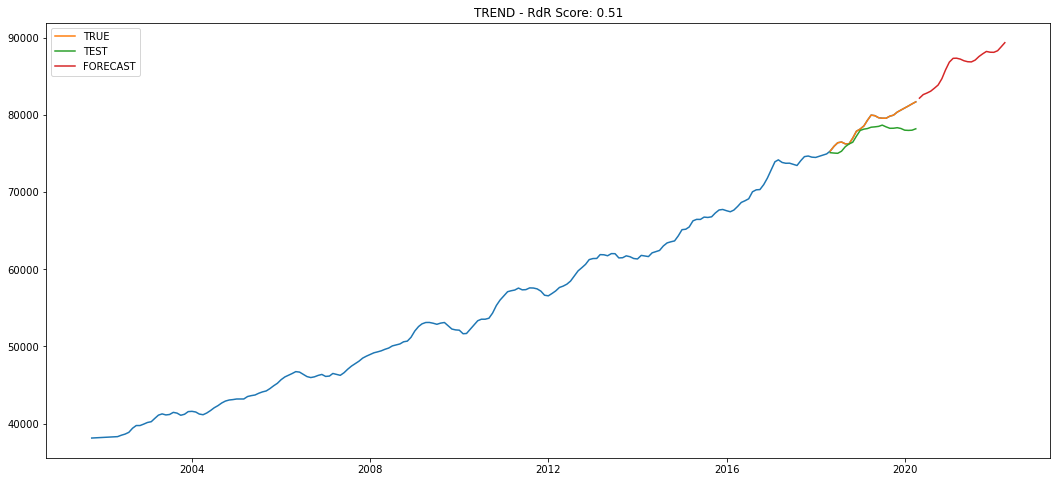

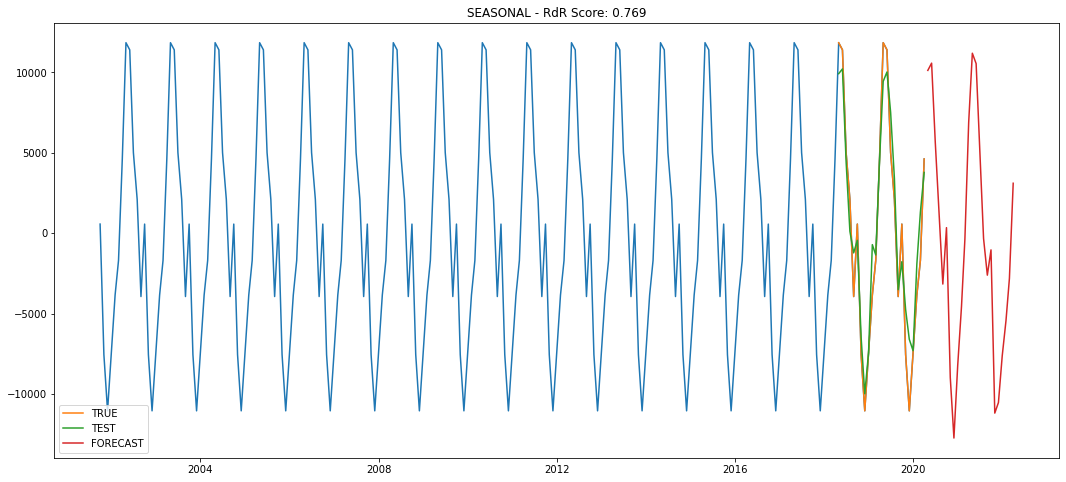

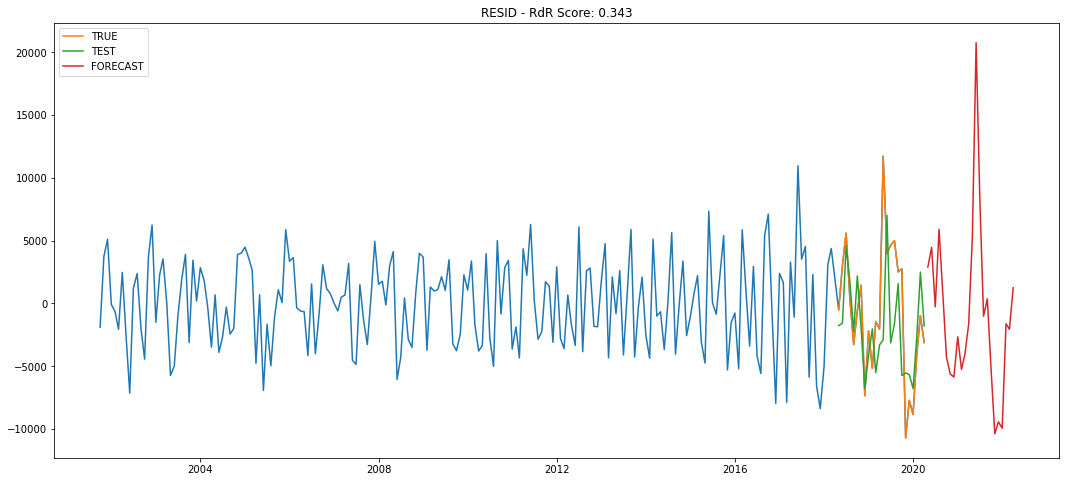

In [89]:
for idx, y_colname in enumerate(dict_ts_sequence['y_colname']):
    fig, ax = plt.subplots(figsize=(18,8))
    ax.plot(ts_orig.index, dict_ts_sequence['dataset_orig'][dict_ts_sequence['y_colname'][idx]])
    ax.plot(testing_pred.index, 
             dict_ts_sequence['dataset_orig'][[dict_ts_sequence['y_colname'][idx]]].iloc[-dict_ts_sequence['n_leads']:, :].values, label = 'TRUE')
    ax.plot(testing_pred.index, testing_pred[y_colname], label = 'TEST')
    ax.plot(forecast_pred.index, forecast_pred[y_colname], label = 'FORECAST')
    #ax.plot(testing_pred.index, scorer_benchmark_dict[y_colname]._pred_rw['Y_PRED'].values, label = 'TEST_RANDOMWALK')
    plt.legend()
    plt.title(y_colname + ' - RdR Score: ' + str(round(scorer_benchmark_dict[y_colname].get_df_viz()['RdR_SCORE'].values[0], 3)))
    plt.show()

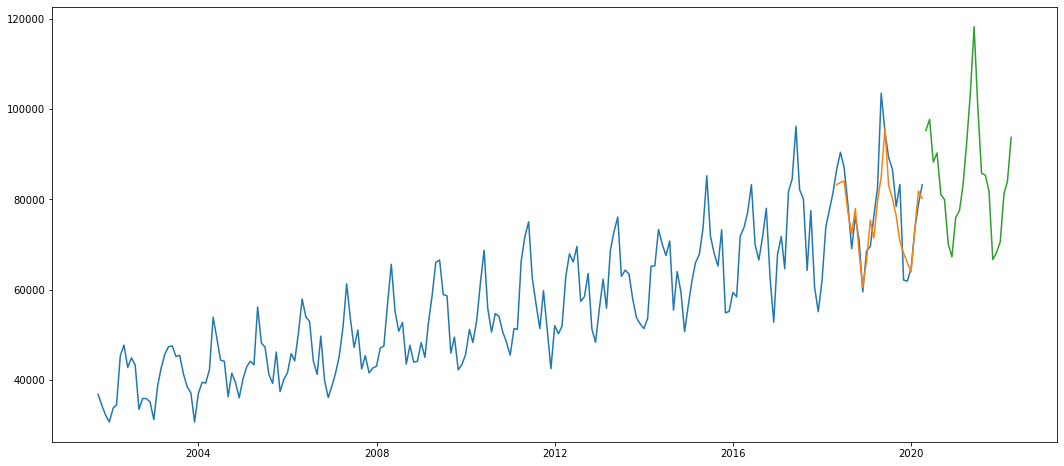

In [90]:
fig, ax = plt.subplots(figsize=(18,8))
ax.plot(ts_orig.index,
         np.sum(dict_ts_sequence['dataset_orig'][['TREND', 'SEASONAL', 'RESID']], axis = 1))
ax.plot(np.sum(testing_pred, axis = 1))
ax.plot(np.sum(forecast_pred, axis = 1))